In [1]:
import pandas as pd
import numpy as np
import os
import urllib.request
import subprocess
from tqdm import tqdm

In [2]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Define paths and URLs
PANEL_URL = 'http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel'
DATA_DIR = '../data/1000g'
PANEL_PATH = f'{DATA_DIR}/integrated_call_samples.panel'
BASE_URL = 'http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/'

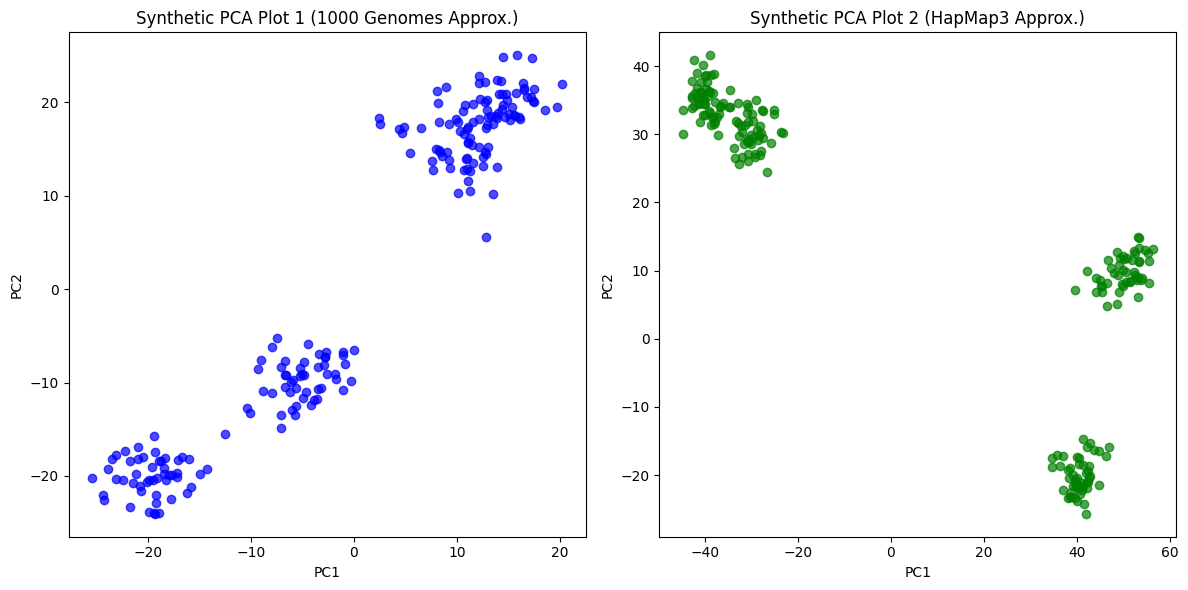

np.float64(0.14195832043377205)

In [2]:
import numpy as np
from scipy.spatial import procrustes
import matplotlib.pyplot as plt

# Generate synthetic PCA data for the first plot (e.g., 1000 Genomes)
np.random.seed(42)
clusters_1 = {
    "CEU": np.random.multivariate_normal([-20, -20], [[10, 2], [2, 5]], 50),
    "YRI": np.random.multivariate_normal([-5, -10], [[8, 3], [3, 6]], 50),
    "CHB": np.random.multivariate_normal([10, 15], [[7, -1], [-1, 8]], 50),
    "JPT": np.random.multivariate_normal([15, 20], [[6, 1], [1, 5]], 50)
}
pca_1 = np.vstack(list(clusters_1.values()))

# Generate synthetic PCA data for the second plot (e.g., HapMap3)
clusters_2 = {
    "CEU": np.random.multivariate_normal([50, 10], [[10, 3], [3, 6]], 50),
    "YRI": np.random.multivariate_normal([40, -20], [[8, 2], [2, 8]], 50),
    "CHB": np.random.multivariate_normal([-30, 30], [[7, 0], [0, 7]], 50),
    "JPT": np.random.multivariate_normal([-40, 35], [[6, 1], [1, 6]], 50)
}
pca_2 = np.vstack(list(clusters_2.values()))

# Perform Procrustes analysis
mtx1, mtx2, disparity = procrustes(pca_1, pca_2)

# Plot synthetic datasets for reference
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(pca_1[:, 0], pca_1[:, 1], c='blue', alpha=0.7, label="Synthetic PCA1")
axs[0].set_title("Synthetic PCA Plot 1 (1000 Genomes Approx.)")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

axs[1].scatter(pca_2[:, 0], pca_2[:, 1], c='green', alpha=0.7, label="Synthetic PCA2")
axs[1].set_title("Synthetic PCA Plot 2 (HapMap3 Approx.)")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

disparity


In [4]:

# Create directory if not exists
os.makedirs(DATA_DIR, exist_ok=True)

# Download panel file if not exists
if not os.path.exists(PANEL_PATH):
    print(f"Downloading panel file from {PANEL_URL}")
    urllib.request.urlretrieve(PANEL_URL, PANEL_PATH)
    print("Download completed")
else:
    print("Panel file already exists")

# Read panel file
print("\nReading panel file...")
panel_data = pd.read_csv(PANEL_PATH, sep='\t')

# Define target populations (corresponding to HapMap3)
target_pops = ['ASW', 'CEU', 'CHB', 'JPT', 'LWK', 'MXL', 'TSI', 'YRI']

# 1. Display overall statistics
print("\n=== 1000 Genomes Phase 3 Overview ===")
print("\nSamples by super population:")
print(panel_data['super_pop'].value_counts())
print("\nSamples by population:")
print(panel_data['pop'].value_counts())

# 2. Analyze target populations
print("\n=== Target Populations Analysis ===")
pop_summary = []
for pop in target_pops:
    pop_data = panel_data[panel_data['pop'] == pop]
    summary = {
        'Population': pop,
        'Sample_Count': len(pop_data),
        'Super_Population': pop_data['super_pop'].iloc[0] if not pop_data.empty else 'Not Found',
        'Males': sum(pop_data['gender'] == 'male'),
        'Females': sum(pop_data['gender'] == 'female')
    }
    pop_summary.append(summary)
    
    print(f"\nPopulation: {pop}")
    print(f"Total samples: {summary['Sample_Count']}")
    print(f"Super population: {summary['Super_Population']}")
    print(f"Gender distribution: {summary['Males']} males, {summary['Females']} females")

# 3. Create summary DataFrame
summary_df = pd.DataFrame(pop_summary)
print("\n=== Summary Table ===")
print(summary_df)

# 4. Save files
# Save target sample IDs
target_samples = panel_data[panel_data['pop'].isin(target_pops)]
target_samples_path = f'{DATA_DIR}/target_samples.txt'
target_samples['sample'].to_csv(target_samples_path, index=False, header=False)
print(f"\nSaved {len(target_samples)} sample IDs to {target_samples_path}")

# Save population summary
summary_path = f'{DATA_DIR}/population_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f"Saved population summary to {summary_path}")

# 5. Print next steps
print("\n=== Next Steps ===")
print("1. Review the population summary above")
print("2. The target_samples.txt file can be used to filter VCF files")
print("3. Proceed with downloading VCF files for specific chromosomes")
print(f"Total samples to extract: {len(target_samples)}")

Panel file already exists

Reading panel file...

=== 1000 Genomes Phase 3 Overview ===

Samples by super population:
super_pop
AFR    661
EAS    504
EUR    503
SAS    489
AMR    347
Name: count, dtype: int64

Samples by population:
pop
GWD    113
YRI    108
IBS    107
TSI    107
CHS    105
PUR    104
JPT    104
CHB    103
GIH    103
ITU    102
STU    102
ESN     99
CEU     99
LWK     99
FIN     99
KHV     99
PJL     96
ACB     96
CLM     94
CDX     93
GBR     91
BEB     86
PEL     85
MSL     85
MXL     64
ASW     61
Name: count, dtype: int64

=== Target Populations Analysis ===

Population: ASW
Total samples: 61
Super population: AFR
Gender distribution: 26 males, 35 females

Population: CEU
Total samples: 99
Super population: EUR
Gender distribution: 49 males, 50 females

Population: CHB
Total samples: 103
Super population: EAS
Gender distribution: 46 males, 57 females

Population: JPT
Total samples: 104
Super population: EAS
Gender distribution: 56 males, 48 females

Population: LWK

In [5]:
def download_file(url, local_path, desc=None):
    """Download a file with progress bar"""
    if os.path.exists(local_path):
        print(f"File already exists: {local_path}")
        return
    
    print(f"Downloading: {url}")
    response = urllib.request.urlopen(url)
    total_size = int(response.headers.get('content-length', 0))
    
    with tqdm(total=total_size, unit='B', unit_scale=True, desc=desc) as pbar:
        urllib.request.urlretrieve(
            url, local_path,
            reporthook=lambda count, block_size, total_size: pbar.update(block_size)
        )

def download_chromosome(chrom):
    """Download VCF and index files for a specific chromosome"""
    # File naming pattern for Phase 3
    vcf_filename = f'ALL.chr{chrom}.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz'
    vcf_url = BASE_URL + vcf_filename
    vcf_path = os.path.join(DATA_DIR, vcf_filename)
    
    # Download VCF file
    download_file(vcf_url, vcf_path, f"Chromosome {chrom}")
    
    # Download index file
    download_file(vcf_url + '.tbi', vcf_path + '.tbi', f"Index chr{chrom}")
    
    return vcf_path

def filter_vcf(vcf_path, output_path, samples_file):
    """Filter VCF file to keep only target samples"""
    cmd = f'bcftools view -S {samples_file} -Oz -o {output_path} {vcf_path}'
    print(f"Filtering VCF file: {cmd}")
    subprocess.run(cmd, shell=True, check=True)
    
    # Index the filtered file
    cmd_index = f'bcftools index {output_path}'
    print("Creating index for filtered file")
    subprocess.run(cmd_index, shell=True, check=True)

# Let's start with chromosome 22 (smallest autosome)
if __name__ == "__main__":
    # Check if bcftools is installed
    try:
        subprocess.run(['bcftools', '--version'], capture_output=True)
        print("bcftools is installed")
    except FileNotFoundError:
        print("Error: bcftools is not installed. Please install it first.")
        print("You can install it using:")
        print("conda install -c bioconda bcftools")
        print("or")
        print("sudo apt-get install bcftools")
        exit(1)

    # Download chromosome 22
    chrom = 22
    vcf_path = download_chromosome(chrom)
    
    # Filter VCF for target samples
    samples_file = os.path.join(DATA_DIR, 'target_samples.txt')
    filtered_vcf = os.path.join(DATA_DIR, f'filtered.chr{chrom}.phase3.vcf.gz')
    
    filter_vcf(vcf_path, filtered_vcf, samples_file)
    
    print("\nProcess completed!")
    print(f"Filtered VCF file: {filtered_vcf}")

bcftools is installed
File already exists: ../data/1000g/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
File already exists: ../data/1000g/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz.tbi
Filtering VCF file: bcftools view -S ../data/1000g/target_samples.txt -Oz -o ../data/1000g/filtered.chr22.phase3.vcf.gz ../data/1000g/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
Creating index for filtered file

Process completed!
Filtered VCF file: ../data/1000g/filtered.chr22.phase3.vcf.gz


In [6]:
# check by small samples
# File paths
VCF_FILE = '../data/1000g/filtered.chr22.phase3.vcf.gz'
SAMPLES_FILE = '../data/1000g/target_samples.txt'

def verify_vcf():
    """Verify the filtered VCF file"""
    
    # 1. Check number of samples in filtered VCF
    cmd_samples = f"bcftools query -l {VCF_FILE}"
    result = subprocess.run(cmd_samples, shell=True, capture_output=True, text=True)
    samples = result.stdout.strip().split('\n')
    print(f"Number of samples in filtered VCF: {len(samples)}")
    
    # Compare with our target samples
    target_samples = pd.read_csv(SAMPLES_FILE, header=None)[0].tolist()
    print(f"Number of target samples: {len(target_samples)}")
    print(f"Samples match: {set(samples) == set(target_samples)}")
    
    # 2. Get basic stats about the VCF
    cmd_stats = f"bcftools stats {VCF_FILE} | grep '^SN'"
    result = subprocess.run(cmd_stats, shell=True, capture_output=True, text=True)
    print("\nVCF Statistics:")
    stats = result.stdout.strip().split('\n')
    for stat in stats:
        if 'number of records' in stat or 'number of SNPs' in stat:
            print(stat.split('\t')[2:][0])
    
    # 3. Check first few variants
    cmd_head = f"bcftools view {VCF_FILE} | head -n 20"
    result = subprocess.run(cmd_head, shell=True, capture_output=True, text=True)
    print("\nFirst few lines of VCF header:")
    header_lines = [line for line in result.stdout.split('\n') if line.startswith('#CHROM')]
    if header_lines:
        columns = header_lines[0].split('\t')
        print(f"Number of columns: {len(columns)}")
        print(f"Sample columns: {len(columns) - 9}")  # VCF has 9 fixed columns before samples

if __name__ == "__main__":
    print("Verifying filtered VCF file...")
    verify_vcf()

Verifying filtered VCF file...
Number of samples in filtered VCF: 745
Number of target samples: 745
Samples match: True

VCF Statistics:
number of records:
number of SNPs:

First few lines of VCF header:


SN	0	number of samples:	745\\
SN	0	number of records:	1103547\\
SN	0	number of no-ALTs:	0\\
SN	0	number of SNPs:	1060388\\
SN	0	number of MNPs:	0\\
SN	0	number of indels:	43230\\
SN	0	number of others:	801\\
SN	0	number of multiallelic sites:	6348\\
SN	0	number of multiallelic SNP sites:	4063

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Constants
SAMPLES_FILE = os.path.join(DATA_DIR, 'target_samples.txt')

def download_file(url, local_path, desc=None):
    """Download a file with progress bar"""
    if os.path.exists(local_path):
        print(f"File already exists: {local_path}")
        return local_path
    
    try:
        response = urllib.request.urlopen(url)
        total_size = int(response.headers.get('content-length', 0))
        
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=desc) as pbar:
            urllib.request.urlretrieve(
                url, local_path,
                reporthook=lambda count, block_size, total_size: pbar.update(block_size)
            )
        return local_path
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        if os.path.exists(local_path):
            os.remove(local_path)
        return None

def process_chromosome(chrom):
    """Process a single chromosome: download and filter"""
    try:
        # File paths
        vcf_filename = f'ALL.chr{chrom}.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz'
        vcf_url = BASE_URL + vcf_filename
        vcf_path = os.path.join(DATA_DIR, vcf_filename)
        filtered_vcf = os.path.join(DATA_DIR, f'filtered.chr{chrom}.phase3.vcf.gz')
        
        # Skip if filtered file already exists
        if os.path.exists(filtered_vcf):
            print(f"Filtered file for chromosome {chrom} already exists")
            return chrom, True
        
        # Download VCF and index files
        print(f"Processing chromosome {chrom}")
        vcf_file = download_file(vcf_url, vcf_path, f"Chr{chrom} VCF")
        if vcf_file:
            index_file = download_file(vcf_url + '.tbi', vcf_path + '.tbi', f"Chr{chrom} Index")
            
            if index_file:
                # Filter VCF
                print(f"Filtering chromosome {chrom}")
                cmd = f'bcftools view -S {SAMPLES_FILE} -Oz -o {filtered_vcf} {vcf_path}'
                subprocess.run(cmd, shell=True, check=True)
                
                # Index filtered file
                cmd_index = f'bcftools index {filtered_vcf}'
                subprocess.run(cmd_index, shell=True, check=True)
                
                # Remove original VCF to save space
                os.remove(vcf_path)
                os.remove(vcf_path + '.tbi')
                
                return chrom, True
                
        return chrom, False
    except Exception as e:
        print(f"Error processing chromosome {chrom}: {e}")
        return chrom, False

def process_all_chromosomes():
    """Process all chromosomes in parallel"""
    # Create data directory if it doesn't exist
    os.makedirs(DATA_DIR, exist_ok=True)
    
    # Process chromosomes 1-22 in parallel
    chromosomes = range(1, 23)
    results = {}
    
    with ThreadPoolExecutor(max_workers=3) as executor:
        # Submit all chromosome processing tasks
        future_to_chrom = {executor.submit(process_chromosome, chrom): chrom 
                          for chrom in chromosomes}
        
        # Process results as they complete
        for future in as_completed(future_to_chrom):
            chrom, success = future.result()
            results[chrom] = success
    
    # Summary
    print("\nProcessing Summary:")
    successful = [chrom for chrom, success in results.items() if success]
    failed = [chrom for chrom, success in results.items() if not success]
    
    print(f"Successfully processed chromosomes: {successful}")
    if failed:
        print(f"Failed to process chromosomes: {failed}")
    
    # Verify all filtered files
    print("\nVerifying filtered files:")
    for chrom in chromosomes:
        filtered_vcf = os.path.join(DATA_DIR, f'filtered.chr{chrom}.phase3.vcf.gz')
        if os.path.exists(filtered_vcf):
            size = os.path.getsize(filtered_vcf) / (1024**3)  # Size in GB
            print(f"Chr{chrom}: {size:.2f} GB")

if __name__ == "__main__":
    start_time = time.time()
    
    print("Starting chromosome processing...")
    process_all_chromosomes()
    
    # Print total execution time
    duration = time.time() - start_time
    hours = int(duration // 3600)
    minutes = int((duration % 3600) // 60)
    seconds = int(duration % 60)
    print(f"\nTotal execution time: {hours}h {minutes}m {seconds}s")

Starting chromosome processing...
Filtered file for chromosome 1 already exists
Filtered file for chromosome 2 already exists
Filtered file for chromosome 3 already exists
Filtered file for chromosome 4 already exists
Filtered file for chromosome 5 already exists
Filtered file for chromosome 6 already exists
Processing chromosome 7
File already exists: ../data/1000g/ALL.chr7.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
Processing chromosome 8
Processing chromosome 9


Chr7 Index:   5%|████▌                                                                                  | 8.19k/157k [00:00<00:03, 40.4kB/s]
Chr8 VCF:   0%|                                                                                                  | 0.00/824M [00:00<?, ?B/s]

Chr7 Index:  36%|████████████████████████████████                                                        | 57.3k/157k [00:00<00:00, 186kB/s]

Chr7 Index: 172kB [00:00, 338kB/s]                                                                                                          
[W::bcf_sr_add_reader] No BGZF EOF marker; file '../data/1000g/ALL.chr7.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz' may be truncated


Chr9 VCF:   0%|                                                                                          | 57.3k/644M [00:00<50:54, 211kB/s]

Filtering chromosome 7



Chr8 VCF:   0%|                                                                                      | 8.19k/824M [00:00<13:31:30, 16.9kB/s]

Chr9 VCF:   0%|                                                                                           | 123k/644M [00:00<48:15, 222kB/s]
Chr8 VCF:   0%|                                                                                        | 57.3k/824M [00:00<2:03:21, 111kB/s]

Chr9 VCF:   0%|                                                                                           | 229k/644M [00:00<28:42, 374kB/s]
Chr8 VCF:   0%|                                                                                           | 147k/824M [00:00<53:18, 258kB/s]
Chr8 VCF:   0%|                                                                                           | 369k/824M [00:00<19:54, 690kB/s]

Chr9 VCF:   0%|                                                                                          | 565k/644M [00:00<10:13, 1.05MB/s]

Chr9 VCF

Filtering chromosome 9



Chr8 VCF:  75%|███████████████████████████████████████████████████████████████████▎                      | 616M/824M [01:47<00:28, 7.24MB/s]
Chr8 VCF:  75%|███████████████████████████████████████████████████████████████████▍                      | 617M/824M [01:47<00:25, 8.12MB/s]
Chr8 VCF:  75%|███████████████████████████████████████████████████████████████████▍                      | 618M/824M [01:47<00:26, 7.64MB/s]
Chr8 VCF:  75%|███████████████████████████████████████████████████████████████████▌                      | 619M/824M [01:47<00:25, 8.05MB/s]
Chr8 VCF:  75%|███████████████████████████████████████████████████████████████████▋                      | 620M/824M [01:47<00:26, 7.83MB/s]
Chr8 VCF:  75%|███████████████████████████████████████████████████████████████████▊                      | 621M/824M [01:47<00:24, 8.28MB/s]
Chr8 VCF:  75%|███████████████████████████████████████████████████████████████████▉                      | 622M/824M [01:47<00:25, 7.79MB/s]
Chr8 VCF:  7

Filtering chromosome 8


[E::bgzf_read_block] Failed to read BGZF block data at offset 784325627 expected 1560 bytes; hread returned 1011
Error: BCF read error


Error processing chromosome 7: Command 'bcftools view -S ../data/1000g/target_samples.txt -Oz -o ../data/1000g/filtered.chr7.phase3.vcf.gz ../data/1000g/ALL.chr7.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz' returned non-zero exit status 9.
Processing chromosome 10


Chr10 VCF:  81%|████████████████████████████████████████████████████████████████████████▏                | 602M/742M [01:10<00:17, 8.02MB/s]

Processing chromosome 11


Chr10 VCF:  81%|████████████████████████████████████████████████████████████████████████▍                | 604M/742M [01:10<00:16, 8.54MB/s]
Chr10 VCF:  82%|████████████████████████████████████████████████████████████████████████▉                | 608M/742M [01:10<00:15, 8.82MB/s]
Chr10 VCF:  82%|█████████████████████████████████████████████████████████████████████████▏               | 610M/742M [01:11<00:15, 8.33MB/s]
Chr10 VCF:  82%|█████████████████████████████████████████████████████████████████████████▎               | 611M/742M [01:11<00:14, 8.78MB/s]
Chr10 VCF:  83%|█████████████████████████████████████████████████████████████████████████▍               | 612M/742M [01:11<00:15, 8.49MB/s]
Chr10 VCF:  83%|█████████████████████████████████████████████████████████████████████████▌               | 613M/742M [01:11<00:14, 8.67MB/s]
Chr10 VCF:  83%|█████████████████████████████████████████████████████████████████████████▋               | 614M/742M [01:11<00:15, 8.46MB/s]
Chr10 VCF:  8

Filtering chromosome 10



Chr11 VCF:  18%|████████████████                                                                         | 132M/735M [00:22<01:27, 6.92MB/s]
Chr11 VCF:  18%|████████████████▏                                                                        | 133M/735M [00:22<01:23, 7.21MB/s]
Chr11 VCF:  18%|████████████████▏                                                                        | 134M/735M [00:22<01:24, 7.11MB/s]
Chr11 VCF:  18%|████████████████▎                                                                        | 135M/735M [00:22<01:24, 7.13MB/s]
Chr11 VCF:  18%|████████████████▍                                                                        | 135M/735M [00:22<01:23, 7.14MB/s]
Chr11 VCF:  19%|████████████████▌                                                                        | 136M/735M [00:23<01:22, 7.29MB/s]
Chr11 VCF:  19%|████████████████▌                                                                        | 137M/735M [00:23<01:20, 7.47MB/s]
Chr11 VCF:  

Filtering chromosome 11
Processing chromosome 12


Chr12 VCF: 710MB [01:13, 9.62MB/s]                                                                                                          
Chr12 Index: 147kB [00:00, 278kB/s]                                                                                                         


Filtering chromosome 12
Processing chromosome 13


Chr13 VCF: 534MB [01:03, 8.41MB/s]                                                                                                          
Chr13 Index: 106kB [00:00, 295kB/s]                                                                                                         


Filtering chromosome 13
Processing chromosome 14


Chr14 VCF: 485MB [00:53, 9.13MB/s]                                                                                                          
Chr14 Index: 98.3kB [00:00, 218kB/s]                                                                                                        


Filtering chromosome 14
Processing chromosome 15


Chr15 VCF: 438MB [00:53, 8.20MB/s]                                                                                                          
Chr15 Index: 90.1kB [00:00, 207kB/s]                                                                                                        


Filtering chromosome 15
Processing chromosome 16


Chr16 VCF:  23%|████████████████████▏                                                                    | 108M/473M [00:23<00:38, 9.42MB/s]

Processing chromosome 17


Chr16 VCF:  23%|████████████████████▋                                                                    | 110M/473M [00:23<00:35, 10.2MB/s]
Chr16 VCF:  24%|█████████████████████▍                                                                   | 114M/473M [00:23<00:42, 8.46MB/s]
Chr16 VCF:  24%|█████████████████████▋                                                                   | 115M/473M [00:23<00:47, 7.60MB/s]
Chr16 VCF:  25%|█████████████████████▊                                                                   | 116M/473M [00:24<00:45, 7.85MB/s]
Chr16 VCF:  25%|█████████████████████▉                                                                   | 117M/473M [00:24<00:49, 7.26MB/s]
Chr16 VCF:  25%|██████████████████████                                                                   | 118M/473M [00:24<00:56, 6.35MB/s]
Chr17 VCF:   0%|▏                                                                                        | 762k/416M [00:01<04:49, 1.44MB/s]
Chr16 VCF:  2

Filtering chromosome 17


Chr16 VCF: 473MB [01:33, 5.06MB/s]                                                                                                          
Chr16 Index: 90.1kB [00:00, 223kB/s]                                                                                                        


Filtering chromosome 16
Processing chromosome 18


Chr18 VCF: 418MB [00:44, 9.33MB/s]                                                                                                          
Chr18 Index: 90.1kB [00:00, 260kB/s]                                                                                                        


Filtering chromosome 18
Processing chromosome 19


Chr19 VCF: 345MB [00:45, 7.63MB/s]                                                                                                          
Chr19 Index: 65.5kB [00:00, 189kB/s]                                                                                                        


Filtering chromosome 19
Processing chromosome 20


Chr20 VCF:  57%|██████████████████████████████████████████████████▌                                      | 186M/327M [00:19<00:12, 11.4MB/s]

Processing chromosome 21


Chr20 VCF:  58%|███████████████████████████████████████████████████▌                                     | 189M/327M [00:19<00:12, 11.2MB/s]
Chr20 VCF:  59%|████████████████████████████████████████████████████▋                                    | 194M/327M [00:20<00:11, 12.1MB/s]
Chr20 VCF:  60%|█████████████████████████████████████████████████████▍                                   | 197M/327M [00:20<00:10, 12.5MB/s]
Chr21 VCF:   0%|                                                                                         | 57.3k/210M [00:00<27:45, 126kB/s]
Chr20 VCF:  61%|██████████████████████████████████████████████████████▏                                  | 199M/327M [00:20<00:10, 12.5MB/s]
Chr20 VCF:  61%|██████████████████████████████████████████████████████▌                                  | 201M/327M [00:20<00:10, 11.6MB/s]
Chr20 VCF:  62%|██████████████████████████████████████████████████████▉                                  | 202M/327M [00:20<00:10, 11.5MB/s]
Chr21 VCF:   

Filtering chromosome 20



Chr21 VCF:  17%|███████████████                                                                         | 35.9M/210M [00:16<01:05, 2.65MB/s]
Chr21 VCF:  17%|███████████████▏                                                                        | 36.3M/210M [00:16<01:02, 2.78MB/s]
Chr21 VCF:  17%|███████████████▎                                                                        | 36.6M/210M [00:16<01:02, 2.79MB/s]
Chr21 VCF:  18%|███████████████▌                                                                        | 37.0M/210M [00:16<00:58, 2.97MB/s]
Chr21 VCF:  18%|███████████████▋                                                                        | 37.3M/210M [00:16<00:58, 2.94MB/s]
Chr21 VCF:  18%|███████████████▊                                                                        | 37.6M/210M [00:16<00:59, 2.89MB/s]
Chr21 VCF:  18%|███████████████▉                                                                        | 38.0M/210M [00:16<00:55, 3.08MB/s]
Chr21 VCF:  

Filtering chromosome 21
Filtered file for chromosome 22 already exists

Processing Summary:
Successfully processed chromosomes: [5, 4, 2, 1, 3, 6, 9, 8, 10, 11, 12, 13, 14, 15, 17, 16, 18, 21, 22, 19, 20]
Failed to process chromosomes: [7]

Verifying filtered files:
Chr1: 0.45 GB
Chr2: 0.48 GB
Chr3: 0.41 GB
Chr4: 0.41 GB
Chr5: 0.36 GB
Chr6: 0.36 GB
Chr7: 0.30 GB
Chr8: 0.32 GB
Chr9: 0.25 GB
Chr10: 0.28 GB
Chr11: 0.28 GB
Chr12: 0.27 GB
Chr13: 0.20 GB
Chr14: 0.19 GB
Chr15: 0.17 GB
Chr16: 0.18 GB
Chr17: 0.16 GB
Chr18: 0.16 GB
Chr19: 0.13 GB
Chr20: 0.13 GB
Chr21: 0.08 GB
Chr22: 0.08 GB

Total execution time: 0h 52m 27s



Chr11 VCF:  55%|███████████████▊             | 401M/735M [04:45<01:34, 3.53MB/s]

Chr12 VCF:  75%|█████████████████████▋       | 532M/710M [04:28<01:01, 2.88MB/s]
Chr11 VCF:  55%|███████████████▊             | 402M/735M [04:45<01:40, 3.31MB/s]

Chr12 VCF:  75%|█████████████████████▋       | 533M/710M [04:29<01:04, 2.76MB/s]
Chr11 VCF:  55%|███████████████▉             | 402M/735M [04:45<01:25, 3.88MB/s]

Chr12 VCF:  75%|█████████████████████▊       | 533M/710M [04:29<00:56, 3.11MB/s]
Chr11 VCF:  55%|███████████████▉             | 403M/735M [04:45<01:24, 3.92MB/s]

Chr12 VCF:  75%|█████████████████████▊       | 533M/710M [04:29<00:59, 3.00MB/s]
Chr11 VCF:  55%|███████████████▉             | 403M/735M [04:45<01:29, 3.68MB/s]

Chr12 VCF:  75%|█████████████████████▊       | 534M/710M [04:29<01:02, 2.84MB/s]
Chr11 VCF:  55%|███████████████▉             | 404M/735M [04:45<01:17, 4.27MB/s]

Chr12 VCF:  75%|█████████████████████▊       | 534M/710M [04:29<00:53, 3.26MB/s]
Chr11 VCF:  55%|█████

Chr11 VCF:  58%|████████████████▊            | 424M/735M [04:51<02:15, 2.28MB/s]
Chr11 VCF:  58%|████████████████▊            | 425M/735M [04:51<02:11, 2.35MB/s]

Chr12 VCF:  77%|██████████████████████▎      | 546M/710M [04:35<01:55, 1.42MB/s]
Chr11 VCF:  58%|████████████████▊            | 425M/735M [04:51<02:16, 2.27MB/s]

Chr12 VCF:  77%|██████████████████████▎      | 546M/710M [04:35<01:59, 1.38MB/s]
Chr11 VCF:  58%|████████████████▊            | 425M/735M [04:51<02:08, 2.41MB/s]

Chr12 VCF:  77%|██████████████████████▎      | 547M/710M [04:35<01:53, 1.44MB/s]
Chr11 VCF:  58%|████████████████▊            | 426M/735M [04:51<02:13, 2.32MB/s]

Chr12 VCF:  77%|██████████████████████▎      | 547M/710M [04:35<01:57, 1.39MB/s]
Chr11 VCF:  58%|████████████████▊            | 426M/735M [04:51<02:12, 2.34MB/s]

Chr12 VCF:  77%|██████████████████████▎      | 547M/710M [04:35<01:52, 1.45MB/s]
Chr11 VCF:  58%|████████████████▊            | 426M/735M [04:51<02:15, 2.28MB/s]
Chr11 VCF:  58%|███████

Chr11 VCF:  60%|█████████████████▎           | 439M/735M [04:57<01:44, 2.84MB/s]

Chr12 VCF:  78%|██████████████████████▋      | 556M/710M [04:40<01:14, 2.08MB/s]
Chr11 VCF:  60%|█████████████████▎           | 439M/735M [04:57<01:57, 2.52MB/s]

Chr12 VCF:  78%|██████████████████████▋      | 556M/710M [04:41<01:22, 1.88MB/s]
Chr11 VCF:  60%|█████████████████▎           | 440M/735M [04:57<01:41, 2.91MB/s]

Chr12 VCF:  78%|██████████████████████▋      | 557M/710M [04:41<01:08, 2.23MB/s]
Chr11 VCF:  60%|█████████████████▎           | 440M/735M [04:57<01:55, 2.56MB/s]

Chr12 VCF:  78%|██████████████████████▋      | 557M/710M [04:41<01:18, 1.96MB/s]
Chr11 VCF:  60%|█████████████████▍           | 440M/735M [04:57<01:37, 3.00MB/s]

Chr12 VCF:  78%|██████████████████████▊      | 557M/710M [04:41<01:14, 2.06MB/s]
Chr11 VCF:  60%|█████████████████▍           | 441M/735M [04:57<01:49, 2.69MB/s]
Chr11 VCF:  60%|█████████████████▍           | 441M/735M [04:57<01:34, 3.10MB/s]

Chr12 VCF:  79%|██████

Chr12 VCF:  81%|███████████████████████▍     | 573M/710M [04:46<00:41, 3.28MB/s]
Chr11 VCF:  62%|██████████████████           | 456M/735M [05:03<01:31, 3.05MB/s]
Chr11 VCF:  62%|██████████████████           | 456M/735M [05:03<01:31, 3.04MB/s]

Chr12 VCF:  81%|███████████████████████▍     | 573M/710M [04:46<00:41, 3.26MB/s]

Chr12 VCF:  81%|███████████████████████▍     | 573M/710M [04:47<00:40, 3.37MB/s]
Chr11 VCF:  62%|██████████████████           | 457M/735M [05:03<01:29, 3.09MB/s]

Chr12 VCF:  81%|███████████████████████▍     | 574M/710M [04:47<00:41, 3.30MB/s]
Chr11 VCF:  62%|██████████████████           | 457M/735M [05:03<01:30, 3.06MB/s]

Chr12 VCF:  81%|███████████████████████▍     | 574M/710M [04:47<00:41, 3.31MB/s]
Chr11 VCF:  62%|██████████████████           | 457M/735M [05:03<01:30, 3.07MB/s]

Chr12 VCF:  81%|███████████████████████▍     | 575M/710M [04:47<00:41, 3.30MB/s]
Chr11 VCF:  62%|██████████████████           | 458M/735M [05:03<01:28, 3.12MB/s]

Chr12 VCF:  81%|██████

Chr12 VCF:  83%|████████████████████████▏    | 591M/710M [04:52<00:33, 3.55MB/s]
Chr11 VCF:  65%|██████████████████▋          | 474M/735M [05:08<01:06, 3.90MB/s]

Chr12 VCF:  83%|████████████████████████▏    | 592M/710M [04:52<00:31, 3.74MB/s]
Chr11 VCF:  65%|██████████████████▋          | 475M/735M [05:08<01:04, 4.06MB/s]

Chr12 VCF:  83%|████████████████████████▏    | 592M/710M [04:52<00:34, 3.47MB/s]
Chr11 VCF:  65%|██████████████████▊          | 475M/735M [05:08<01:06, 3.89MB/s]

Chr12 VCF:  83%|████████████████████████▏    | 592M/710M [04:52<00:30, 3.81MB/s]
Chr11 VCF:  65%|██████████████████▊          | 476M/735M [05:08<01:03, 4.10MB/s]

Chr12 VCF:  83%|████████████████████████▏    | 593M/710M [04:52<00:31, 3.78MB/s]
Chr11 VCF:  65%|██████████████████▊          | 476M/735M [05:09<01:00, 4.27MB/s]

Chr12 VCF:  84%|████████████████████████▏    | 593M/710M [04:52<00:29, 4.00MB/s]
Chr11 VCF:  65%|██████████████████▊          | 477M/735M [05:09<01:02, 4.12MB/s]

Chr12 VCF:  84%|██████

Chr12 VCF:  86%|█████████████████████████    | 614M/710M [04:57<00:21, 4.56MB/s]
Chr11 VCF:  68%|███████████████████▋         | 499M/735M [05:14<00:46, 5.08MB/s]

Chr12 VCF:  86%|█████████████████████████    | 614M/710M [04:57<00:22, 4.27MB/s]
Chr11 VCF:  68%|███████████████████▋         | 499M/735M [05:14<00:49, 4.79MB/s]

Chr12 VCF:  87%|█████████████████████████    | 615M/710M [04:58<00:21, 4.51MB/s]
Chr11 VCF:  68%|███████████████████▋         | 500M/735M [05:14<00:47, 4.95MB/s]

Chr12 VCF:  87%|█████████████████████████    | 615M/710M [04:58<00:20, 4.65MB/s]
Chr11 VCF:  68%|███████████████████▊         | 501M/735M [05:14<00:47, 4.91MB/s]

Chr12 VCF:  87%|█████████████████████████▏   | 615M/710M [04:58<00:20, 4.64MB/s]
Chr11 VCF:  68%|███████████████████▊         | 501M/735M [05:14<00:45, 5.14MB/s]

Chr12 VCF:  87%|█████████████████████████▏   | 616M/710M [04:58<00:21, 4.33MB/s]
Chr11 VCF:  68%|███████████████████▊         | 502M/735M [05:14<00:48, 4.84MB/s]

Chr12 VCF:  87%|██████

Chr12 VCF:  90%|██████████████████████████   | 637M/710M [05:03<00:15, 4.58MB/s]
Chr11 VCF:  71%|████████████████████▋        | 525M/735M [05:19<00:40, 5.18MB/s]

Chr12 VCF:  90%|██████████████████████████   | 638M/710M [05:03<00:14, 4.98MB/s]
Chr11 VCF:  72%|████████████████████▋        | 525M/735M [05:19<00:40, 5.21MB/s]

Chr12 VCF:  90%|██████████████████████████   | 639M/710M [05:03<00:14, 4.83MB/s]
Chr11 VCF:  72%|████████████████████▊        | 526M/735M [05:19<00:40, 5.17MB/s]

Chr12 VCF:  90%|██████████████████████████   | 639M/710M [05:03<00:15, 4.69MB/s]
Chr11 VCF:  72%|████████████████████▊        | 526M/735M [05:19<00:40, 5.17MB/s]

Chr12 VCF:  90%|██████████████████████████   | 640M/710M [05:03<00:15, 4.54MB/s]
Chr11 VCF:  72%|████████████████████▊        | 527M/735M [05:19<00:39, 5.31MB/s]

Chr12 VCF:  90%|██████████████████████████▏  | 640M/710M [05:03<00:14, 5.00MB/s]
Chr11 VCF:  72%|████████████████████▊        | 528M/735M [05:19<00:39, 5.26MB/s]

Chr12 VCF:  90%|██████

Chr11 VCF:  76%|██████████████████████       | 558M/735M [05:24<00:21, 8.41MB/s]

Chr12 VCF:  93%|██████████████████████████▉  | 660M/710M [05:08<00:12, 4.08MB/s]
Chr11 VCF:  76%|██████████████████████       | 559M/735M [05:24<00:20, 8.39MB/s]

Chr12 VCF:  93%|██████████████████████████▉  | 661M/710M [05:08<00:10, 4.87MB/s]
Chr11 VCF:  76%|██████████████████████       | 560M/735M [05:24<00:21, 7.99MB/s]
Chr11 VCF:  76%|██████████████████████▏      | 561M/735M [05:24<00:21, 8.25MB/s]

Chr12 VCF:  93%|███████████████████████████  | 662M/710M [05:08<00:11, 4.39MB/s]
Chr11 VCF:  76%|██████████████████████▏      | 561M/735M [05:24<00:22, 7.54MB/s]

Chr12 VCF:  93%|███████████████████████████  | 662M/710M [05:08<00:12, 3.99MB/s]
Chr11 VCF:  77%|██████████████████████▏      | 562M/735M [05:24<00:23, 7.36MB/s]

Chr12 VCF:  93%|███████████████████████████  | 663M/710M [05:08<00:12, 3.97MB/s]
Chr11 VCF:  77%|██████████████████████▏      | 563M/735M [05:25<00:23, 7.30MB/s]

Chr12 VCF:  93%|██████

Chr11 VCF:  80%|███████████████████████▏     | 589M/735M [05:29<00:24, 5.89MB/s]
Chr11 VCF:  80%|███████████████████████▎     | 590M/735M [05:29<00:23, 6.09MB/s]

Chr12 VCF:  96%|███████████████████████████▊ | 681M/710M [05:13<00:06, 4.22MB/s]
Chr11 VCF:  80%|███████████████████████▎     | 590M/735M [05:29<00:23, 6.11MB/s]

Chr12 VCF:  96%|███████████████████████████▊ | 682M/710M [05:13<00:06, 4.35MB/s]
Chr11 VCF:  80%|███████████████████████▎     | 591M/735M [05:29<00:24, 5.81MB/s]

Chr12 VCF:  96%|███████████████████████████▊ | 682M/710M [05:13<00:07, 3.95MB/s]
Chr11 VCF:  81%|███████████████████████▎     | 591M/735M [05:30<00:24, 5.83MB/s]

Chr12 VCF:  96%|███████████████████████████▉ | 683M/710M [05:13<00:06, 4.07MB/s]
Chr11 VCF:  81%|███████████████████████▎     | 592M/735M [05:30<00:24, 5.92MB/s]

Chr12 VCF:  96%|███████████████████████████▉ | 683M/710M [05:13<00:06, 4.14MB/s]
Chr11 VCF:  81%|███████████████████████▍     | 593M/735M [05:30<00:23, 5.93MB/s]

Chr12 VCF:  96%|██████

Chr11 VCF:  84%|████████████████████████▍    | 618M/735M [05:34<00:22, 5.20MB/s]

Chr12 VCF:  99%|████████████████████████████▊| 704M/710M [05:18<00:01, 5.14MB/s]
Chr11 VCF:  84%|████████████████████████▍    | 619M/735M [05:35<00:21, 5.43MB/s]

Chr12 VCF:  99%|████████████████████████████▊| 705M/710M [05:18<00:01, 5.13MB/s]
Chr11 VCF:  84%|████████████████████████▍    | 619M/735M [05:35<00:21, 5.40MB/s]

Chr12 VCF:  99%|████████████████████████████▊| 706M/710M [05:18<00:00, 5.23MB/s]

Chr12 VCF:  99%|████████████████████████████▊| 706M/710M [05:19<00:00, 5.56MB/s]
Chr11 VCF:  84%|████████████████████████▍    | 620M/735M [05:35<00:21, 5.39MB/s]
Chr11 VCF:  84%|████████████████████████▍    | 621M/735M [05:35<00:20, 5.45MB/s]

Chr12 VCF: 100%|████████████████████████████▊| 707M/710M [05:19<00:00, 5.32MB/s]
Chr11 VCF:  85%|████████████████████████▌    | 621M/735M [05:35<00:21, 5.34MB/s]

Chr12 VCF: 100%|████████████████████████████▉| 707M/710M [05:19<00:00, 5.43MB/s]

Chr12 VCF: 100%|█████

Filtering chromosome 12



Chr11 VCF:  86%|████████████████████████▊    | 629M/735M [05:36<00:18, 5.79MB/s]
Chr11 VCF:  86%|████████████████████████▊    | 630M/735M [05:36<00:17, 5.95MB/s]
Chr11 VCF:  86%|████████████████████████▉    | 630M/735M [05:37<00:18, 5.76MB/s]
Chr11 VCF:  86%|████████████████████████▉    | 631M/735M [05:37<00:17, 6.03MB/s]
Chr11 VCF:  86%|████████████████████████▉    | 632M/735M [05:37<00:17, 5.80MB/s]
Chr11 VCF:  86%|████████████████████████▉    | 632M/735M [05:37<00:17, 5.95MB/s]
Chr11 VCF:  86%|████████████████████████▉    | 633M/735M [05:37<00:17, 5.78MB/s]
Chr11 VCF:  86%|█████████████████████████    | 634M/735M [05:37<00:16, 5.97MB/s]
Chr11 VCF:  86%|█████████████████████████    | 634M/735M [05:37<00:16, 5.93MB/s]
Chr11 VCF:  86%|█████████████████████████    | 635M/735M [05:37<00:16, 6.08MB/s]
Chr11 VCF:  87%|█████████████████████████    | 636M/735M [05:37<00:16, 6.04MB/s]
Chr11 VCF:  87%|█████████████████████████    | 636M/735M [05:38<00:16, 5.82MB/s]
Chr11 VCF:  87%|███████████

Chr11 VCF:  94%|███████████████████████████▎ | 692M/735M [05:47<00:08, 5.03MB/s]
Chr11 VCF:  94%|███████████████████████████▎ | 693M/735M [05:47<00:09, 4.51MB/s]
Chr11 VCF:  94%|███████████████████████████▎ | 693M/735M [05:47<00:09, 4.55MB/s]
Chr11 VCF:  94%|███████████████████████████▍ | 694M/735M [05:47<00:08, 5.02MB/s]
Chr11 VCF:  95%|███████████████████████████▍ | 694M/735M [05:47<00:08, 4.78MB/s]
Chr11 VCF:  95%|███████████████████████████▍ | 695M/735M [05:48<00:08, 4.66MB/s]
Chr11 VCF:  95%|███████████████████████████▍ | 695M/735M [05:48<00:08, 4.63MB/s]
Chr11 VCF:  95%|███████████████████████████▍ | 696M/735M [05:48<00:07, 5.04MB/s]
Chr11 VCF:  95%|███████████████████████████▍ | 697M/735M [05:48<00:07, 4.99MB/s]
Chr11 VCF:  95%|███████████████████████████▌ | 697M/735M [05:48<00:08, 4.64MB/s]
Chr11 VCF:  95%|███████████████████████████▌ | 698M/735M [05:48<00:07, 4.82MB/s]
Chr11 VCF:  95%|███████████████████████████▌ | 698M/735M [05:48<00:07, 5.07MB/s]
Chr11 VCF:  95%|████████████

Filtering chromosome 11
Processing chromosome 13


Chr13 VCF:  17%|████▉                       | 93.3M/534M [00:43<03:56, 1.86MB/s]

Processing chromosome 14


Chr13 VCF:  18%|████▉                       | 94.0M/534M [00:43<03:48, 1.92MB/s]
Chr13 VCF:  18%|████▉                       | 94.3M/534M [00:43<03:43, 1.96MB/s]
Chr13 VCF:  18%|████▉                       | 94.7M/534M [00:43<03:41, 1.98MB/s]
Chr13 VCF:  18%|████▉                       | 95.1M/534M [00:44<03:37, 2.02MB/s]
Chr13 VCF:  18%|█████                       | 95.8M/534M [00:44<03:29, 2.09MB/s]
Chr13 VCF:  18%|█████                       | 96.2M/534M [00:44<03:27, 2.11MB/s]
Chr14 VCF:   0%|                             | 926k/485M [00:00<05:54, 1.37MB/s]
Chr13 VCF:  18%|█████                       | 96.6M/534M [00:44<03:24, 2.14MB/s]
Chr13 VCF:  18%|█████                       | 97.0M/534M [00:45<03:22, 2.16MB/s]
Chr13 VCF:  18%|█████▏                      | 97.8M/534M [00:45<03:18, 2.20MB/s]
Chr14 VCF:   1%|▍                           | 6.56M/485M [00:01<01:04, 7.44MB/s]
Chr13 VCF:  18%|█████▏                      | 98.0M/534M [00:45<03:48, 1.90MB/s]
Chr13 VCF:  18%|█████▏      

Chr13 VCF:  22%|██████▍                      | 119M/534M [00:55<02:29, 2.78MB/s]
Chr14 VCF:  13%|███▋                        | 63.6M/485M [00:11<01:14, 5.68MB/s]
Chr13 VCF:  22%|██████▌                      | 120M/534M [00:55<02:33, 2.70MB/s]
Chr13 VCF:  23%|██████▌                      | 120M/534M [00:55<02:23, 2.88MB/s]
Chr14 VCF:  13%|███▊                        | 65.3M/485M [00:12<01:16, 5.51MB/s]
Chr13 VCF:  23%|██████▌                      | 120M/534M [00:55<02:36, 2.64MB/s]
Chr13 VCF:  23%|██████▌                      | 121M/534M [00:56<02:25, 2.83MB/s]
Chr13 VCF:  23%|██████▌                      | 121M/534M [00:56<02:16, 3.03MB/s]
Chr13 VCF:  23%|██████▌                      | 121M/534M [00:56<02:26, 2.82MB/s]
Chr13 VCF:  23%|██████▌                      | 122M/534M [00:56<02:18, 2.98MB/s]
Chr13 VCF:  23%|██████▋                      | 122M/534M [00:56<02:15, 3.04MB/s]
Chr13 VCF:  23%|██████▋                      | 123M/534M [00:56<02:19, 2.96MB/s]
Chr13 VCF:  23%|██████▋     

Chr13 VCF:  32%|█████████▏                   | 170M/534M [01:07<01:24, 4.32MB/s]
Chr13 VCF:  32%|█████████▎                   | 170M/534M [01:07<01:25, 4.27MB/s]
Chr13 VCF:  32%|█████████▎                   | 171M/534M [01:07<01:20, 4.50MB/s]
Chr13 VCF:  32%|█████████▎                   | 172M/534M [01:07<01:19, 4.57MB/s]
Chr13 VCF:  32%|█████████▎                   | 172M/534M [01:07<01:24, 4.26MB/s]
Chr13 VCF:  32%|█████████▍                   | 173M/534M [01:07<01:20, 4.49MB/s]
Chr13 VCF:  32%|█████████▍                   | 173M/534M [01:07<01:19, 4.51MB/s]
Chr13 VCF:  33%|█████████▍                   | 174M/534M [01:08<01:22, 4.36MB/s]
Chr13 VCF:  33%|█████████▍                   | 174M/534M [01:08<01:23, 4.31MB/s]
Chr13 VCF:  33%|█████████▌                   | 175M/534M [01:08<01:17, 4.66MB/s]
Chr13 VCF:  33%|█████████▌                   | 175M/534M [01:08<01:17, 4.63MB/s]
Chr13 VCF:  33%|█████████▌                   | 176M/534M [01:08<01:20, 4.43MB/s]
Chr13 VCF:  33%|█████████▌  

Processing chromosome 15



Chr13 VCF:  44%|████████████▊                | 235M/534M [01:17<01:00, 4.98MB/s]
Chr14 VCF:  33%|█████████▍                   | 159M/485M [00:34<01:40, 3.27MB/s]

Chr13 VCF:  44%|████████████▊                | 235M/534M [01:17<01:12, 4.12MB/s]
Chr13 VCF:  44%|████████████▊                | 236M/534M [01:18<01:09, 4.28MB/s]
Chr13 VCF:  44%|████████████▊                | 236M/534M [01:18<01:13, 4.06MB/s]
Chr14 VCF:  33%|█████████▌                   | 160M/485M [00:34<01:19, 4.11MB/s]

Chr13 VCF:  44%|████████████▊                | 237M/534M [01:18<01:23, 3.56MB/s]
Chr13 VCF:  44%|████████████▉                | 237M/534M [01:18<01:22, 3.61MB/s]

Chr15 VCF:   0%|                           | 57.3k/438M [00:00<1:00:14, 121kB/s]
Chr13 VCF:  45%|████████████▉                | 238M/534M [01:18<01:19, 3.73MB/s]
Chr14 VCF:  33%|█████████▋                   | 162M/485M [00:34<01:11, 4.51MB/s]

Chr13 VCF:  45%|████████████▉                | 238M/534M [01:18<01:29, 3.31MB/s]
Chr13 VCF:  45%|███████

Chr13 VCF:  48%|█████████████▉               | 256M/534M [01:24<01:34, 2.94MB/s]

Chr15 VCF:   4%|█                           | 17.5M/438M [00:06<03:29, 2.01MB/s]
Chr13 VCF:  48%|█████████████▉               | 256M/534M [01:24<01:47, 2.58MB/s]

Chr13 VCF:  48%|█████████████▉               | 256M/534M [01:24<01:43, 2.69MB/s]
Chr14 VCF:  38%|██████████▉                  | 182M/485M [00:40<02:16, 2.22MB/s]

Chr13 VCF:  48%|█████████████▉               | 257M/534M [01:24<01:42, 2.71MB/s]
Chr14 VCF:  38%|██████████▉                  | 183M/485M [00:41<02:13, 2.27MB/s]

Chr15 VCF:   4%|█▏                          | 18.2M/438M [00:06<03:24, 2.06MB/s]
Chr13 VCF:  48%|█████████████▉               | 257M/534M [01:24<01:54, 2.42MB/s]

Chr13 VCF:  48%|█████████████▉               | 257M/534M [01:25<01:47, 2.59MB/s]
Chr14 VCF:  38%|██████████▉                  | 183M/485M [00:41<01:59, 2.52MB/s]

Chr15 VCF:   4%|█▏                          | 18.6M/438M [00:07<03:37, 1.93MB/s]
Chr13 VCF:  48%|██████

Chr15 VCF:   7%|█▉                          | 29.8M/438M [00:12<02:44, 2.48MB/s]
Chr13 VCF:  51%|██████████████▋              | 271M/534M [01:30<02:14, 1.95MB/s]
Chr14 VCF:  41%|███████████▉                 | 199M/485M [00:46<01:39, 2.88MB/s]

Chr13 VCF:  51%|██████████████▋              | 271M/534M [01:30<02:14, 1.96MB/s]
Chr14 VCF:  41%|███████████▉                 | 200M/485M [00:46<01:26, 3.30MB/s]

Chr13 VCF:  51%|██████████████▋              | 271M/534M [01:30<02:12, 1.98MB/s]
Chr14 VCF:  41%|███████████▉                 | 200M/485M [00:46<01:35, 3.00MB/s]

Chr13 VCF:  51%|██████████████▋              | 271M/534M [01:30<02:12, 1.98MB/s]
Chr13 VCF:  51%|██████████████▋              | 272M/534M [01:30<02:08, 2.05MB/s]

Chr15 VCF:   7%|█▉                          | 30.9M/438M [00:12<02:55, 2.33MB/s]
Chr13 VCF:  51%|██████████████▊              | 272M/534M [01:30<02:09, 2.03MB/s]

Chr13 VCF:  51%|██████████████▊              | 272M/534M [01:31<02:08, 2.04MB/s]
Chr14 VCF:  41%|███████

Chr13 VCF:  53%|███████████████▏             | 280M/534M [01:35<01:55, 2.19MB/s]
Chr14 VCF:  45%|████████████▉                | 217M/485M [00:52<01:19, 3.36MB/s]

Chr13 VCF:  53%|███████████████▎             | 281M/534M [01:36<01:44, 2.43MB/s]
Chr14 VCF:  45%|████████████▉                | 217M/485M [00:52<01:18, 3.40MB/s]

Chr13 VCF:  53%|███████████████▎             | 281M/534M [01:36<01:54, 2.21MB/s]
Chr14 VCF:  45%|████████████▉                | 217M/485M [00:52<01:17, 3.45MB/s]

Chr13 VCF:  53%|███████████████▎             | 281M/534M [01:36<01:54, 2.20MB/s]
Chr14 VCF:  45%|█████████████                | 218M/485M [00:52<01:16, 3.50MB/s]

Chr13 VCF:  53%|███████████████▎             | 282M/534M [01:36<01:41, 2.48MB/s]
Chr14 VCF:  45%|█████████████                | 218M/485M [00:52<01:16, 3.48MB/s]

Chr13 VCF:  53%|███████████████▎             | 282M/534M [01:36<01:52, 2.24MB/s]
Chr14 VCF:  45%|█████████████                | 219M/485M [00:52<01:17, 3.44MB/s]

Chr13 VCF:  53%|██████

Chr13 VCF:  55%|████████████████             | 296M/534M [01:41<01:17, 3.09MB/s]
Chr14 VCF:  48%|█████████████▉               | 234M/485M [00:57<01:34, 2.66MB/s]

Chr13 VCF:  55%|████████████████             | 296M/534M [01:41<01:13, 3.24MB/s]
Chr14 VCF:  48%|█████████████▉               | 234M/485M [00:58<01:34, 2.66MB/s]

Chr13 VCF:  55%|████████████████             | 296M/534M [01:41<01:21, 2.93MB/s]
Chr14 VCF:  48%|█████████████▉               | 234M/485M [00:58<01:29, 2.81MB/s]

Chr13 VCF:  56%|████████████████             | 297M/534M [01:41<01:19, 3.00MB/s]
Chr14 VCF:  48%|██████████████               | 234M/485M [00:58<01:29, 2.79MB/s]

Chr15 VCF:  15%|████▏                       | 66.3M/438M [00:24<02:14, 2.77MB/s]
Chr13 VCF:  56%|████████████████▏            | 297M/534M [01:42<01:11, 3.30MB/s]

Chr15 VCF:  15%|████▎                       | 66.6M/438M [00:24<02:06, 2.95MB/s]
Chr13 VCF:  56%|████████████████▏            | 297M/534M [01:42<01:18, 3.00MB/s]

Chr15 VCF:  15%|████▎ 

Chr13 VCF:  58%|████████████████▉            | 312M/534M [01:47<01:12, 3.08MB/s]

Chr15 VCF:  19%|█████▏                      | 81.5M/438M [00:29<01:57, 3.04MB/s]
Chr13 VCF:  58%|████████████████▉            | 312M/534M [01:47<01:13, 3.02MB/s]

Chr15 VCF:  19%|█████▏                      | 81.8M/438M [00:29<02:03, 2.89MB/s]
Chr13 VCF:  59%|████████████████▉            | 312M/534M [01:47<01:12, 3.04MB/s]

Chr15 VCF:  19%|█████▏                      | 82.2M/438M [00:29<01:57, 3.03MB/s]
Chr13 VCF:  59%|████████████████▉            | 313M/534M [01:47<01:09, 3.17MB/s]
Chr14 VCF:  52%|██████████████▉              | 250M/485M [01:03<01:19, 2.96MB/s]

Chr13 VCF:  59%|█████████████████            | 313M/534M [01:47<01:13, 3.02MB/s]
Chr14 VCF:  52%|██████████████▉              | 250M/485M [01:03<01:19, 2.95MB/s]

Chr13 VCF:  59%|█████████████████            | 314M/534M [01:47<01:10, 3.12MB/s]
Chr14 VCF:  52%|██████████████▉              | 251M/485M [01:03<01:16, 3.05MB/s]

Chr13 VCF:  59%|██████

Chr13 VCF:  62%|█████████████████▉           | 330M/534M [01:52<01:01, 3.34MB/s]
Chr14 VCF:  56%|████████████████             | 269M/485M [01:09<00:53, 4.06MB/s]

Chr13 VCF:  62%|█████████████████▉           | 330M/534M [01:52<00:59, 3.42MB/s]
Chr14 VCF:  56%|████████████████▏            | 270M/485M [01:09<00:52, 4.11MB/s]

Chr13 VCF:  62%|█████████████████▉           | 331M/534M [01:52<00:59, 3.43MB/s]
Chr14 VCF:  56%|████████████████▏            | 270M/485M [01:09<00:54, 3.96MB/s]

Chr13 VCF:  62%|█████████████████▉           | 331M/534M [01:53<00:59, 3.41MB/s]
Chr13 VCF:  62%|██████████████████           | 332M/534M [01:53<00:58, 3.43MB/s]

Chr15 VCF:  23%|██████▊                      | 103M/438M [00:35<01:26, 3.89MB/s]
Chr13 VCF:  62%|██████████████████           | 332M/534M [01:53<00:58, 3.44MB/s]

Chr15 VCF:  24%|██████▊                      | 103M/438M [00:35<01:23, 4.02MB/s]
Chr13 VCF:  62%|██████████████████           | 332M/534M [01:53<00:57, 3.52MB/s]

Chr15 VCF:  24%|██████

Chr13 VCF:  66%|███████████████████▏         | 352M/534M [01:58<00:56, 3.21MB/s]
Chr14 VCF:  61%|█████████████████▌           | 294M/485M [01:14<00:41, 4.65MB/s]

Chr13 VCF:  66%|███████████████████▏         | 353M/534M [01:58<00:57, 3.13MB/s]
Chr14 VCF:  61%|█████████████████▌           | 294M/485M [01:14<00:40, 4.68MB/s]

Chr15 VCF:  28%|████████▏                    | 123M/438M [00:40<01:23, 3.76MB/s]
Chr13 VCF:  66%|███████████████████▏         | 353M/534M [01:58<00:59, 3.04MB/s]

Chr13 VCF:  66%|███████████████████▏         | 353M/534M [01:58<00:56, 3.18MB/s]
Chr14 VCF:  61%|█████████████████▋           | 295M/485M [01:14<00:41, 4.58MB/s]

Chr13 VCF:  66%|███████████████████▏         | 354M/534M [01:58<00:54, 3.30MB/s]
Chr14 VCF:  61%|█████████████████▋           | 296M/485M [01:14<00:41, 4.53MB/s]

Chr15 VCF:  28%|████████▏                    | 124M/438M [00:40<01:27, 3.58MB/s]
Chr13 VCF:  66%|███████████████████▏         | 354M/534M [01:58<00:56, 3.21MB/s]

Chr13 VCF:  66%|██████

Chr14 VCF:  66%|██████████████████▉          | 318M/485M [01:19<00:34, 4.90MB/s]

Chr13 VCF:  69%|████████████████████▏        | 371M/534M [02:03<00:45, 3.62MB/s]
Chr14 VCF:  66%|███████████████████          | 318M/485M [01:20<00:34, 4.78MB/s]

Chr13 VCF:  70%|████████████████████▏        | 371M/534M [02:03<00:48, 3.32MB/s]
Chr14 VCF:  66%|███████████████████          | 319M/485M [01:20<00:36, 4.52MB/s]

Chr13 VCF:  70%|████████████████████▏        | 372M/534M [02:04<00:46, 3.50MB/s]
Chr13 VCF:  70%|████████████████████▏        | 372M/534M [02:04<00:43, 3.75MB/s]

Chr15 VCF:  32%|█████████▍                   | 142M/438M [00:46<01:53, 2.62MB/s]
Chr14 VCF:  66%|███████████████████▏         | 320M/485M [01:20<00:34, 4.82MB/s]

Chr13 VCF:  70%|████████████████████▏        | 373M/534M [02:04<00:48, 3.34MB/s]
Chr13 VCF:  70%|████████████████████▎        | 373M/534M [02:04<00:46, 3.49MB/s]
Chr14 VCF:  66%|███████████████████▏         | 321M/485M [01:20<00:34, 4.72MB/s]

Chr13 VCF:  70%|██████

Chr14 VCF:  71%|████████████████████▍        | 342M/485M [01:25<00:33, 4.21MB/s]

Chr13 VCF:  74%|█████████████████████▎       | 393M/534M [02:09<00:35, 3.97MB/s]
Chr14 VCF:  71%|████████████████████▍        | 343M/485M [01:25<00:35, 4.04MB/s]

Chr13 VCF:  74%|█████████████████████▎       | 393M/534M [02:09<00:33, 4.14MB/s]
Chr13 VCF:  74%|█████████████████████▍       | 394M/534M [02:09<00:33, 4.24MB/s]
Chr14 VCF:  71%|████████████████████▌        | 344M/485M [01:26<00:32, 4.35MB/s]

Chr13 VCF:  74%|█████████████████████▍       | 394M/534M [02:09<00:35, 3.99MB/s]
Chr14 VCF:  71%|████████████████████▌        | 344M/485M [01:26<00:34, 4.15MB/s]

Chr13 VCF:  74%|█████████████████████▍       | 395M/534M [02:10<00:34, 4.04MB/s]
Chr14 VCF:  71%|████████████████████▌        | 344M/485M [01:26<00:34, 4.05MB/s]

Chr13 VCF:  74%|█████████████████████▍       | 395M/534M [02:10<00:32, 4.27MB/s]
Chr14 VCF:  71%|████████████████████▌        | 345M/485M [01:26<00:33, 4.18MB/s]

Chr13 VCF:  74%|██████

Chr13 VCF:  77%|██████████████████████▍      | 413M/534M [02:15<00:40, 2.99MB/s]

Chr15 VCF:  39%|███████████▎                 | 170M/438M [00:57<01:18, 3.43MB/s]
Chr13 VCF:  77%|██████████████████████▍      | 414M/534M [02:15<00:39, 3.02MB/s]

Chr15 VCF:  39%|███████████▎                 | 170M/438M [00:57<01:18, 3.42MB/s]
Chr14 VCF:  76%|█████████████████████▉       | 367M/485M [01:31<00:27, 4.32MB/s]

Chr13 VCF:  78%|██████████████████████▍      | 414M/534M [02:15<00:39, 3.02MB/s]
Chr14 VCF:  76%|█████████████████████▉       | 367M/485M [01:31<00:24, 4.77MB/s]

Chr13 VCF:  78%|██████████████████████▌      | 414M/534M [02:15<00:38, 3.07MB/s]
Chr14 VCF:  76%|█████████████████████▉       | 368M/485M [01:31<00:24, 4.70MB/s]

Chr13 VCF:  78%|██████████████████████▌      | 415M/534M [02:15<00:38, 3.08MB/s]
Chr14 VCF:  76%|██████████████████████       | 368M/485M [01:31<00:24, 4.73MB/s]

Chr13 VCF:  78%|██████████████████████▌      | 415M/534M [02:15<00:37, 3.14MB/s]
Chr14 VCF:  76%|██████

Chr13 VCF:  81%|███████████████████████▍     | 431M/534M [02:20<00:28, 3.60MB/s]
Chr14 VCF:  82%|███████████████████████▊     | 398M/485M [01:36<00:17, 4.87MB/s]

Chr13 VCF:  81%|███████████████████████▍     | 432M/534M [02:20<00:29, 3.48MB/s]
Chr14 VCF:  82%|███████████████████████▊     | 399M/485M [01:36<00:17, 5.02MB/s]

Chr13 VCF:  81%|███████████████████████▍     | 432M/534M [02:20<00:31, 3.27MB/s]
Chr14 VCF:  82%|███████████████████████▊     | 399M/485M [01:37<00:16, 5.24MB/s]

Chr13 VCF:  81%|███████████████████████▍     | 432M/534M [02:20<00:29, 3.45MB/s]
Chr14 VCF:  82%|███████████████████████▉     | 400M/485M [01:37<00:16, 5.07MB/s]

Chr13 VCF:  81%|███████████████████████▌     | 433M/534M [02:20<00:29, 3.43MB/s]
Chr14 VCF:  82%|███████████████████████▉     | 400M/485M [01:37<00:17, 4.91MB/s]

Chr13 VCF:  81%|███████████████████████▌     | 433M/534M [02:21<00:30, 3.30MB/s]
Chr13 VCF:  81%|███████████████████████▌     | 434M/534M [02:21<00:28, 3.49MB/s]
Chr14 VCF:  83%|███████

Chr13 VCF:  85%|████████████████████████▌    | 452M/534M [02:26<00:27, 2.99MB/s]
Chr14 VCF:  86%|████████████████████████▉    | 417M/485M [01:42<00:40, 1.70MB/s]

Chr13 VCF:  85%|████████████████████████▌    | 453M/534M [02:26<00:29, 2.80MB/s]
Chr14 VCF:  86%|████████████████████████▉    | 417M/485M [01:43<00:41, 1.63MB/s]

Chr13 VCF:  85%|████████████████████████▌    | 453M/534M [02:26<00:26, 3.04MB/s]
Chr14 VCF:  86%|████████████████████████▉    | 418M/485M [01:43<00:39, 1.72MB/s]

Chr13 VCF:  85%|████████████████████████▋    | 454M/534M [02:27<00:27, 2.94MB/s]
Chr14 VCF:  86%|████████████████████████▉    | 418M/485M [01:43<00:42, 1.60MB/s]

Chr13 VCF:  85%|████████████████████████▋    | 454M/534M [02:27<00:24, 3.25MB/s]
Chr14 VCF:  86%|████████████████████████▉    | 418M/485M [01:43<00:43, 1.56MB/s]

Chr13 VCF:  85%|████████████████████████▋    | 454M/534M [02:27<00:27, 2.92MB/s]
Chr13 VCF:  85%|████████████████████████▋    | 455M/534M [02:27<00:26, 2.94MB/s]

Chr15 VCF:  48%|██████

Chr15 VCF:  50%|██████████████▍              | 218M/438M [01:15<02:35, 1.42MB/s]

Chr15 VCF:  50%|██████████████▍              | 218M/438M [01:15<02:34, 1.42MB/s]
Chr13 VCF:  88%|█████████████████████████▌   | 470M/534M [02:33<00:38, 1.65MB/s]

Chr15 VCF:  50%|██████████████▍              | 218M/438M [01:15<02:35, 1.42MB/s]
Chr13 VCF:  88%|█████████████████████████▌   | 470M/534M [02:33<00:37, 1.71MB/s]

Chr13 VCF:  88%|█████████████████████████▌   | 470M/534M [02:34<00:37, 1.67MB/s]
Chr14 VCF:  88%|█████████████████████████▍   | 426M/485M [01:50<00:44, 1.33MB/s]

Chr13 VCF:  88%|█████████████████████████▌   | 471M/534M [02:34<00:36, 1.76MB/s]
Chr13 VCF:  88%|█████████████████████████▌   | 471M/534M [02:34<00:37, 1.69MB/s]

Chr15 VCF:  50%|██████████████▍              | 219M/438M [01:16<02:29, 1.47MB/s]
Chr13 VCF:  88%|█████████████████████████▌   | 471M/534M [02:34<00:35, 1.78MB/s]

Chr13 VCF:  88%|█████████████████████████▌   | 471M/534M [02:34<00:37, 1.68MB/s]
Chr14 VCF:  88%|██████

Chr13 VCF:  90%|██████████████████████████▏  | 483M/534M [02:40<00:24, 2.05MB/s]

Chr15 VCF:  53%|███████████████▌             | 235M/438M [01:22<01:10, 2.91MB/s]
Chr13 VCF:  90%|██████████████████████████▏  | 483M/534M [02:40<00:26, 1.94MB/s]

Chr15 VCF:  54%|███████████████▌             | 235M/438M [01:22<01:20, 2.52MB/s]
Chr13 VCF:  91%|██████████████████████████▏  | 483M/534M [02:40<00:27, 1.84MB/s]

Chr15 VCF:  54%|███████████████▌             | 235M/438M [01:22<01:14, 2.74MB/s]
Chr13 VCF:  91%|██████████████████████████▎  | 483M/534M [02:40<00:27, 1.84MB/s]

Chr13 VCF:  91%|██████████████████████████▎  | 484M/534M [02:40<00:27, 1.80MB/s]
Chr14 VCF:  90%|██████████████████████████▏  | 437M/485M [01:57<00:30, 1.56MB/s]

Chr13 VCF:  91%|██████████████████████████▎  | 484M/534M [02:41<00:27, 1.80MB/s]
Chr14 VCF:  90%|██████████████████████████▏  | 438M/485M [01:57<00:30, 1.58MB/s]

Chr13 VCF:  91%|██████████████████████████▎  | 484M/534M [02:41<00:26, 1.86MB/s]
Chr14 VCF:  90%|██████

Chr14 VCF:  92%|██████████████████████████▋  | 448M/485M [02:02<00:18, 2.07MB/s]

Chr13 VCF:  93%|██████████████████████████▉  | 495M/534M [02:46<00:18, 2.09MB/s]
Chr14 VCF:  92%|██████████████████████████▊  | 448M/485M [02:02<00:17, 2.08MB/s]

Chr15 VCF:  57%|████████████████▌            | 250M/438M [01:28<01:06, 2.83MB/s]
Chr13 VCF:  93%|██████████████████████████▉  | 495M/534M [02:46<00:16, 2.33MB/s]

Chr15 VCF:  57%|████████████████▌            | 251M/438M [01:28<01:07, 2.78MB/s]
Chr14 VCF:  92%|██████████████████████████▊  | 448M/485M [02:02<00:17, 2.09MB/s]

Chr13 VCF:  93%|██████████████████████████▉  | 495M/534M [02:46<00:18, 2.10MB/s]
Chr14 VCF:  92%|██████████████████████████▊  | 449M/485M [02:02<00:17, 2.08MB/s]

Chr13 VCF:  93%|██████████████████████████▉  | 496M/534M [02:46<00:16, 2.36MB/s]

Chr15 VCF:  57%|████████████████▋            | 252M/438M [01:28<01:04, 2.89MB/s]
Chr13 VCF:  93%|██████████████████████████▉  | 496M/534M [02:46<00:17, 2.11MB/s]

Chr15 VCF:  57%|█████

Chr15 VCF:  61%|█████████████████▌           | 266M/438M [01:34<01:15, 2.28MB/s]
Chr13 VCF:  95%|███████████████████████████▌ | 507M/534M [02:51<00:12, 2.20MB/s]

Chr15 VCF:  61%|█████████████████▌           | 266M/438M [01:34<01:14, 2.30MB/s]
Chr13 VCF:  95%|███████████████████████████▌ | 507M/534M [02:52<00:11, 2.37MB/s]

Chr15 VCF:  61%|█████████████████▌           | 266M/438M [01:34<01:13, 2.34MB/s]
Chr13 VCF:  95%|███████████████████████████▌ | 508M/534M [02:52<00:12, 2.19MB/s]

Chr15 VCF:  61%|█████████████████▋           | 267M/438M [01:34<01:14, 2.30MB/s]
Chr13 VCF:  95%|███████████████████████████▌ | 508M/534M [02:52<00:10, 2.38MB/s]
Chr14 VCF:  95%|███████████████████████████▋ | 463M/485M [02:08<00:09, 2.31MB/s]

Chr13 VCF:  95%|███████████████████████████▌ | 508M/534M [02:52<00:11, 2.20MB/s]

Chr13 VCF:  95%|███████████████████████████▌ | 509M/534M [02:52<00:10, 2.34MB/s]
Chr14 VCF:  96%|███████████████████████████▋ | 464M/485M [02:08<00:08, 2.58MB/s]

Chr15 VCF:  61%|██████

Chr15 VCF:  63%|██████████████████▎          | 278M/438M [01:39<01:14, 2.17MB/s]
Chr13 VCF:  98%|████████████████████████████▎| 522M/534M [02:57<00:03, 3.41MB/s]

Chr15 VCF:  63%|██████████████████▍          | 278M/438M [01:39<01:12, 2.21MB/s]
Chr13 VCF:  98%|████████████████████████████▍| 523M/534M [02:57<00:03, 3.53MB/s]

Chr15 VCF:  63%|██████████████████▍          | 278M/438M [01:40<01:14, 2.14MB/s]
Chr13 VCF:  98%|████████████████████████████▍| 523M/534M [02:58<00:03, 3.35MB/s]

Chr15 VCF:  63%|██████████████████▍          | 278M/438M [01:40<01:11, 2.23MB/s]
Chr13 VCF:  98%|████████████████████████████▍| 524M/534M [02:58<00:02, 3.63MB/s]

Chr13 VCF:  98%|████████████████████████████▍| 524M/534M [02:58<00:02, 3.81MB/s]
Chr14 VCF:  98%|████████████████████████████▌| 477M/485M [02:14<00:03, 2.55MB/s]

Chr13 VCF:  98%|████████████████████████████▍| 525M/534M [02:58<00:02, 3.53MB/s]
Chr14 VCF:  98%|████████████████████████████▌| 478M/485M [02:14<00:02, 2.60MB/s]

Chr13 VCF:  98%|██████

Filtering chromosome 13




Chr15 VCF:  65%|██████████████████▉          | 287M/438M [01:43<01:11, 2.12MB/s]
Chr14 Index: 98.3kB [00:00, 224kB/s]                                            


Chr15 VCF:  65%|██████████████████▉          | 287M/438M [01:44<01:12, 2.09MB/s]

Chr15 VCF:  66%|███████████████████          | 287M/438M [01:44<01:06, 2.27MB/s]

Filtering chromosome 14




Chr15 VCF:  66%|███████████████████          | 288M/438M [01:44<01:08, 2.21MB/s]

Chr15 VCF:  66%|███████████████████          | 288M/438M [01:44<01:08, 2.21MB/s]

Chr15 VCF:  66%|███████████████████          | 288M/438M [01:44<01:03, 2.36MB/s]

Chr15 VCF:  66%|███████████████████          | 288M/438M [01:44<01:02, 2.38MB/s]

Chr15 VCF:  66%|███████████████████          | 289M/438M [01:44<01:05, 2.28MB/s]

Chr15 VCF:  66%|███████████████████          | 289M/438M [01:44<01:01, 2.44MB/s]

Chr15 VCF:  66%|███████████████████▏         | 289M/438M [01:44<01:01, 2.43MB/s]

Chr15 VCF:  66%|███████████████████▏         | 290M/438M [01:45<01:02, 2.38MB/s]

Chr15 VCF:  66%|███████████████████▏         | 290M/438M [01:45<00:59, 2.51MB/s]

Chr15 VCF:  66%|███████████████████▏         | 290M/438M [01:45<00:58, 2.55MB/s]

Chr15 VCF:  66%|███████████████████▏         | 290M/438M [01:45<00:59, 2.47MB/s]

Chr15 VCF:  66%|███████████████████▏         | 291M/438M [01:45<00:57, 2.57MB/s]

Chr15 VCF:  66

Chr15 VCF:  74%|█████████████████████▍       | 324M/438M [01:57<00:37, 3.04MB/s]

Chr15 VCF:  74%|█████████████████████▍       | 325M/438M [01:57<00:36, 3.10MB/s]

Chr15 VCF:  74%|█████████████████████▌       | 325M/438M [01:57<00:37, 3.02MB/s]

Chr15 VCF:  74%|█████████████████████▌       | 326M/438M [01:57<00:39, 2.89MB/s]

Chr15 VCF:  74%|█████████████████████▌       | 326M/438M [01:58<00:41, 2.70MB/s]

Chr15 VCF:  74%|█████████████████████▌       | 326M/438M [01:58<00:42, 2.61MB/s]

Chr15 VCF:  75%|█████████████████████▌       | 327M/438M [01:58<00:43, 2.56MB/s]

Chr15 VCF:  75%|█████████████████████▋       | 327M/438M [01:58<00:43, 2.56MB/s]

Chr15 VCF:  75%|█████████████████████▋       | 328M/438M [01:58<00:43, 2.55MB/s]

Chr15 VCF:  75%|█████████████████████▋       | 328M/438M [01:59<00:42, 2.57MB/s]

Chr15 VCF:  75%|█████████████████████▋       | 329M/438M [01:59<00:41, 2.61MB/s]

Chr15 VCF:  75%|█████████████████████▊       | 329M/438M [01:59<00:40, 2.67MB/s]

Chr15 VCF:  75%|

Chr15 VCF:  81%|███████████████████████▌     | 356M/438M [02:11<00:36, 2.29MB/s]

Chr15 VCF:  81%|███████████████████████▌     | 356M/438M [02:11<00:31, 2.62MB/s]

Chr15 VCF:  81%|███████████████████████▌     | 356M/438M [02:12<00:35, 2.33MB/s]

Chr15 VCF:  81%|███████████████████████▌     | 357M/438M [02:12<00:34, 2.39MB/s]

Chr15 VCF:  81%|███████████████████████▋     | 357M/438M [02:12<00:33, 2.46MB/s]

Chr15 VCF:  82%|███████████████████████▋     | 358M/438M [02:12<00:32, 2.51MB/s]

Chr15 VCF:  82%|███████████████████████▋     | 358M/438M [02:12<00:31, 2.54MB/s]

Chr15 VCF:  82%|███████████████████████▋     | 359M/438M [02:13<00:37, 2.14MB/s]

Chr15 VCF:  82%|███████████████████████▋     | 359M/438M [02:13<00:34, 2.30MB/s]

Chr15 VCF:  82%|███████████████████████▊     | 359M/438M [02:13<00:36, 2.19MB/s]

Chr15 VCF:  82%|███████████████████████▊     | 360M/438M [02:13<00:36, 2.13MB/s]

Chr15 VCF:  82%|███████████████████████▊     | 360M/438M [02:13<00:37, 2.10MB/s]

Chr15 VCF:  82%|

Chr15 VCF:  89%|█████████████████████████▊   | 390M/438M [02:28<00:20, 2.34MB/s]

Chr15 VCF:  89%|█████████████████████████▊   | 390M/438M [02:28<00:20, 2.33MB/s]

Chr15 VCF:  89%|█████████████████████████▊   | 391M/438M [02:28<00:20, 2.33MB/s]

Chr15 VCF:  89%|█████████████████████████▊   | 391M/438M [02:28<00:20, 2.30MB/s]

Chr15 VCF:  89%|█████████████████████████▉   | 391M/438M [02:28<00:20, 2.25MB/s]

Chr15 VCF:  89%|█████████████████████████▉   | 392M/438M [02:29<00:18, 2.59MB/s]

Chr15 VCF:  89%|█████████████████████████▉   | 392M/438M [02:29<00:20, 2.29MB/s]

Chr15 VCF:  89%|█████████████████████████▉   | 392M/438M [02:29<00:19, 2.34MB/s]

Chr15 VCF:  90%|█████████████████████████▉   | 393M/438M [02:29<00:20, 2.26MB/s]

Chr15 VCF:  90%|█████████████████████████▉   | 393M/438M [02:29<00:20, 2.20MB/s]

Chr15 VCF:  90%|██████████████████████████   | 393M/438M [02:29<00:20, 2.23MB/s]

Chr15 VCF:  90%|██████████████████████████   | 394M/438M [02:29<00:18, 2.46MB/s]

Chr15 VCF:  90%|

Chr15 VCF:  97%|████████████████████████████ | 425M/438M [02:42<00:07, 1.75MB/s]

Chr15 VCF:  97%|████████████████████████████▏| 425M/438M [02:42<00:07, 1.73MB/s]

Chr15 VCF:  97%|████████████████████████████▏| 426M/438M [02:42<00:07, 1.72MB/s]

Chr15 VCF:  97%|████████████████████████████▏| 426M/438M [02:42<00:07, 1.73MB/s]

Chr15 VCF:  97%|████████████████████████████▏| 426M/438M [02:42<00:07, 1.73MB/s]

Chr15 VCF:  97%|████████████████████████████▏| 427M/438M [02:42<00:06, 1.75MB/s]

Chr15 VCF:  97%|████████████████████████████▏| 427M/438M [02:43<00:06, 1.76MB/s]

Chr15 VCF:  97%|████████████████████████████▎| 427M/438M [02:43<00:06, 1.79MB/s]

Chr15 VCF:  98%|████████████████████████████▎| 427M/438M [02:43<00:06, 1.80MB/s]

Chr15 VCF:  98%|████████████████████████████▎| 428M/438M [02:43<00:05, 1.82MB/s]

Chr15 VCF:  98%|████████████████████████████▎| 428M/438M [02:43<00:05, 1.84MB/s]

Chr15 VCF:  98%|████████████████████████████▎| 428M/438M [02:43<00:05, 1.86MB/s]

Chr15 VCF:  98%|

Filtering chromosome 15
Processing chromosome 16


Chr16 VCF:   6%|█▊                          | 30.6M/473M [00:13<03:21, 2.19MB/s]

Processing chromosome 17



Chr16 VCF:   7%|█▊                          | 31.4M/473M [00:14<03:17, 2.24MB/s]
Chr16 VCF:   7%|█▉                          | 31.8M/473M [00:14<03:14, 2.27MB/s]
Chr16 VCF:   7%|█▉                          | 32.3M/473M [00:14<03:11, 2.31MB/s]
Chr16 VCF:   7%|█▉                          | 32.7M/473M [00:14<03:08, 2.34MB/s]
Chr17 VCF:   0%|                             | 795k/416M [00:00<04:20, 1.60MB/s]
Chr16 VCF:   7%|█▉                          | 33.1M/473M [00:14<03:05, 2.37MB/s]
Chr16 VCF:   7%|█▉                          | 33.5M/473M [00:15<02:58, 2.47MB/s]
Chr16 VCF:   7%|█▉                          | 33.7M/473M [00:15<03:05, 2.37MB/s]
Chr16 VCF:   7%|██                          | 34.4M/473M [00:15<02:58, 2.47MB/s]
Chr17 VCF:   1%|▎                           | 4.55M/416M [00:01<01:26, 4.73MB/s]
Chr16 VCF:   7%|██                          | 34.7M/473M [00:15<03:19, 2.20MB/s]
Chr16 VCF:   7%|██                          | 35.3M/473M [00:15<03:13, 2.26MB/s]
Chr17 VCF:   2%|▍          

Chr17 VCF:   7%|██                          | 30.2M/416M [00:16<05:54, 1.09MB/s]
Chr16 VCF:  15%|████▎                       | 72.1M/473M [00:30<02:33, 2.62MB/s]
Chr16 VCF:  15%|████▎                       | 73.0M/473M [00:30<02:30, 2.67MB/s]
Chr16 VCF:  16%|████▎                       | 73.5M/473M [00:30<02:28, 2.70MB/s]
Chr17 VCF:   7%|██                          | 31.0M/416M [00:16<05:42, 1.12MB/s]
Chr16 VCF:  16%|████▍                       | 74.0M/473M [00:30<02:52, 2.32MB/s]
Chr16 VCF:  16%|████▍                       | 74.4M/473M [00:31<02:44, 2.43MB/s]
Chr16 VCF:  16%|████▍                       | 74.8M/473M [00:31<02:34, 2.59MB/s]
Chr16 VCF:  16%|████▍                       | 75.1M/473M [00:31<02:53, 2.30MB/s]
Chr16 VCF:  16%|████▍                       | 75.4M/473M [00:31<03:02, 2.18MB/s]
Chr16 VCF:  16%|████▍                       | 75.7M/473M [00:31<02:45, 2.40MB/s]
Chr16 VCF:  16%|████▌                       | 76.3M/473M [00:31<02:39, 2.49MB/s]
Chr16 VCF:  16%|████▌       

Chr16 VCF:  22%|██████▎                      | 103M/473M [00:44<02:32, 2.43MB/s]
Chr16 VCF:  22%|██████▎                      | 103M/473M [00:44<02:27, 2.50MB/s]
Chr16 VCF:  22%|██████▎                      | 104M/473M [00:44<02:38, 2.34MB/s]
Chr16 VCF:  22%|██████▎                      | 104M/473M [00:44<02:25, 2.54MB/s]
Chr16 VCF:  22%|██████▍                      | 104M/473M [00:44<02:15, 2.73MB/s]
Chr16 VCF:  22%|██████▍                      | 105M/473M [00:44<02:33, 2.40MB/s]
Chr16 VCF:  22%|██████▍                      | 105M/473M [00:44<02:20, 2.63MB/s]
Chr16 VCF:  22%|██████▍                      | 105M/473M [00:44<02:38, 2.32MB/s]
Chr16 VCF:  22%|██████▍                      | 106M/473M [00:44<02:20, 2.62MB/s]
Chr16 VCF:  22%|██████▍                      | 106M/473M [00:45<02:40, 2.30MB/s]
Chr16 VCF:  22%|██████▌                      | 106M/473M [00:45<02:19, 2.62MB/s]
Chr17 VCF:  16%|████▌                       | 68.5M/416M [00:31<01:31, 3.81MB/s]
Chr16 VCF:  23%|██████▌     

Processing chromosome 18



Chr16 VCF:  25%|███████▎                     | 120M/473M [00:51<02:56, 2.00MB/s]
Chr17 VCF:  20%|█████▋                      | 84.9M/416M [00:37<02:59, 1.84MB/s]

Chr16 VCF:  25%|███████▍                     | 120M/473M [00:51<03:06, 1.90MB/s]
Chr16 VCF:  25%|███████▍                     | 121M/473M [00:51<02:50, 2.07MB/s]

Chr18 VCF:   0%|                          | 8.19k/418M [00:00<2:37:07, 44.4kB/s]
Chr16 VCF:  26%|███████▍                     | 121M/473M [00:51<03:17, 1.79MB/s]

Chr18 VCF:   0%|                             | 57.3k/418M [00:00<38:36, 180kB/s]
Chr16 VCF:  26%|███████▍                     | 121M/473M [00:51<03:20, 1.76MB/s]

Chr18 VCF:   0%|                              | 229k/418M [00:00<12:48, 544kB/s]
Chr16 VCF:  26%|███████▍                     | 122M/473M [00:51<03:27, 1.70MB/s]

Chr18 VCF:   0%|                             | 680k/418M [00:00<05:14, 1.33MB/s]
Chr16 VCF:  26%|███████▍                     | 122M/473M [00:51<03:16, 1.79MB/s]

Chr18 VCF:   0%|     

Chr18 VCF:   3%|▊                           | 12.0M/418M [00:07<04:55, 1.37MB/s]
Chr16 VCF:  28%|████████                     | 132M/473M [00:58<03:54, 1.46MB/s]

Chr18 VCF:   3%|▊                           | 12.2M/418M [00:07<04:56, 1.37MB/s]
Chr16 VCF:  28%|████████                     | 132M/473M [00:58<03:30, 1.63MB/s]

Chr18 VCF:   3%|▊                           | 12.4M/418M [00:07<04:45, 1.42MB/s]
Chr16 VCF:  28%|████████                     | 132M/473M [00:58<03:36, 1.57MB/s]

Chr18 VCF:   3%|▊                           | 12.6M/418M [00:07<04:49, 1.40MB/s]
Chr17 VCF:  23%|██████▍                     | 95.6M/416M [00:44<04:16, 1.25MB/s]

Chr16 VCF:  28%|████████                     | 132M/473M [00:58<03:34, 1.59MB/s]
Chr17 VCF:  23%|██████▍                     | 95.8M/416M [00:44<04:01, 1.32MB/s]

Chr18 VCF:   3%|▊                           | 13.0M/418M [00:07<04:41, 1.44MB/s]
Chr16 VCF:  28%|████████                     | 133M/473M [00:58<03:29, 1.63MB/s]

Chr18 VCF:   3%|▉     

Chr18 VCF:   5%|█▍                          | 22.1M/418M [00:13<04:58, 1.33MB/s]
Chr17 VCF:  25%|███████▎                     | 105M/416M [00:50<03:36, 1.44MB/s]

Chr16 VCF:  30%|████████▊                    | 143M/473M [01:04<02:56, 1.88MB/s]
Chr17 VCF:  25%|███████▎                     | 105M/416M [00:50<03:52, 1.34MB/s]

Chr16 VCF:  30%|████████▊                    | 143M/473M [01:04<02:53, 1.90MB/s]
Chr17 VCF:  25%|███████▎                     | 105M/416M [00:51<03:46, 1.37MB/s]

Chr16 VCF:  30%|████████▊                    | 144M/473M [01:05<02:51, 1.92MB/s]
Chr17 VCF:  25%|███████▎                     | 105M/416M [00:51<03:40, 1.41MB/s]

Chr18 VCF:   5%|█▌                          | 23.0M/418M [00:14<04:30, 1.46MB/s]

Chr16 VCF:  30%|████████▊                    | 144M/473M [01:05<02:47, 1.96MB/s]
Chr17 VCF:  25%|███████▎                     | 106M/416M [00:51<03:36, 1.44MB/s]

Chr18 VCF:   6%|█▌                          | 23.4M/418M [00:14<04:16, 1.54MB/s]
Chr17 VCF:  25%|██████

Chr16 VCF:  33%|█████████▍                   | 155M/473M [01:11<03:21, 1.58MB/s]

Chr18 VCF:   8%|██▎                         | 34.6M/418M [00:20<03:57, 1.61MB/s]

Chr16 VCF:  33%|█████████▌                   | 155M/473M [01:12<03:21, 1.58MB/s]
Chr17 VCF:  28%|████████                     | 115M/416M [00:58<03:12, 1.56MB/s]
Chr17 VCF:  28%|████████                     | 116M/416M [00:58<02:53, 1.73MB/s]

Chr16 VCF:  33%|█████████▌                   | 155M/473M [01:12<03:20, 1.58MB/s]
Chr17 VCF:  28%|████████                     | 116M/416M [00:58<03:14, 1.54MB/s]

Chr16 VCF:  33%|█████████▌                   | 156M/473M [01:12<03:26, 1.54MB/s]
Chr17 VCF:  28%|████████                     | 116M/416M [00:58<03:21, 1.49MB/s]

Chr18 VCF:   8%|██▎                         | 35.3M/418M [00:21<04:25, 1.44MB/s]

Chr16 VCF:  33%|█████████▌                   | 156M/473M [01:12<03:20, 1.59MB/s]
Chr17 VCF:  28%|████████                     | 116M/416M [00:58<03:15, 1.53MB/s]

Chr18 VCF:   9%|██▍  

Chr16 VCF:  35%|██████████▏                  | 167M/473M [01:19<03:00, 1.70MB/s]
Chr17 VCF:  31%|█████████                    | 130M/416M [01:05<02:08, 2.23MB/s]

Chr16 VCF:  35%|██████████▎                  | 168M/473M [01:19<02:55, 1.74MB/s]
Chr17 VCF:  31%|█████████                    | 130M/416M [01:05<01:55, 2.48MB/s]

Chr16 VCF:  35%|██████████▎                  | 168M/473M [01:19<02:43, 1.87MB/s]
Chr17 VCF:  31%|█████████                    | 130M/416M [01:05<02:10, 2.19MB/s]

Chr16 VCF:  35%|██████████▎                  | 168M/473M [01:19<02:50, 1.79MB/s]
Chr17 VCF:  31%|█████████                    | 131M/416M [01:05<01:50, 2.59MB/s]

Chr18 VCF:  11%|███▏                        | 47.8M/418M [00:28<03:09, 1.95MB/s]
Chr16 VCF:  36%|██████████▎                  | 168M/473M [01:19<02:45, 1.85MB/s]

Chr18 VCF:  12%|███▏                        | 48.2M/418M [00:28<03:05, 2.00MB/s]
Chr16 VCF:  36%|██████████▎                  | 169M/473M [01:20<02:39, 1.91MB/s]
Chr17 VCF:  32%|███████

Chr16 VCF:  38%|██████████▉                  | 179M/473M [01:26<03:29, 1.41MB/s]
Chr17 VCF:  35%|██████████▏                  | 147M/416M [01:13<01:43, 2.60MB/s]

Chr16 VCF:  38%|██████████▉                  | 179M/473M [01:27<03:39, 1.34MB/s]

Chr18 VCF:  15%|████                        | 60.7M/418M [00:36<03:18, 1.80MB/s]
Chr17 VCF:  35%|██████████▏                  | 147M/416M [01:13<01:57, 2.30MB/s]
Chr17 VCF:  35%|██████████▎                  | 147M/416M [01:13<01:52, 2.39MB/s]

Chr16 VCF:  38%|███████████                  | 180M/473M [01:27<03:35, 1.36MB/s]
Chr17 VCF:  35%|██████████▎                  | 148M/416M [01:13<01:52, 2.39MB/s]

Chr18 VCF:  15%|████                        | 61.2M/418M [00:36<03:31, 1.69MB/s]
Chr16 VCF:  38%|███████████                  | 180M/473M [01:27<03:30, 1.40MB/s]
Chr17 VCF:  36%|██████████▎                  | 148M/416M [01:13<01:50, 2.43MB/s]

Chr16 VCF:  38%|███████████                  | 180M/473M [01:27<03:21, 1.45MB/s]
Chr17 VCF:  36%|███████

Chr18 VCF:  17%|████▋                       | 70.8M/418M [00:42<04:08, 1.40MB/s]
Chr16 VCF:  40%|███████████▌                 | 188M/473M [01:34<03:52, 1.23MB/s]
Chr17 VCF:  39%|███████████▎                 | 163M/416M [01:20<02:03, 2.05MB/s]

Chr16 VCF:  40%|███████████▌                 | 188M/473M [01:34<03:45, 1.26MB/s]
Chr17 VCF:  39%|███████████▎                 | 163M/416M [01:20<02:22, 1.78MB/s]

Chr16 VCF:  40%|███████████▌                 | 188M/473M [01:34<03:37, 1.31MB/s]
Chr17 VCF:  39%|███████████▍                 | 163M/416M [01:20<02:19, 1.81MB/s]

Chr18 VCF:  17%|████▊                       | 71.6M/418M [00:43<03:50, 1.50MB/s]
Chr16 VCF:  40%|███████████▌                 | 189M/473M [01:34<03:35, 1.32MB/s]
Chr17 VCF:  39%|███████████▍                 | 164M/416M [01:20<02:15, 1.85MB/s]

Chr16 VCF:  40%|███████████▌                 | 189M/473M [01:34<03:31, 1.35MB/s]
Chr17 VCF:  39%|███████████▍                 | 164M/416M [01:20<02:09, 1.94MB/s]

Chr16 VCF:  40%|███████

Chr16 VCF:  42%|████████████▏                | 199M/473M [01:41<03:54, 1.17MB/s]
Chr17 VCF:  42%|████████████▎                | 176M/416M [01:28<02:48, 1.42MB/s]

Chr18 VCF:  19%|█████▍                      | 81.5M/418M [00:50<04:17, 1.31MB/s]
Chr16 VCF:  42%|████████████▏                | 200M/473M [01:42<03:58, 1.15MB/s]

Chr18 VCF:  20%|█████▍                      | 81.7M/418M [00:50<04:13, 1.33MB/s]
Chr16 VCF:  42%|████████████▏                | 200M/473M [01:42<03:58, 1.15MB/s]

Chr16 VCF:  42%|████████████▏                | 200M/473M [01:42<04:03, 1.12MB/s]
Chr17 VCF:  42%|████████████▎                | 177M/416M [01:28<02:44, 1.45MB/s]

Chr16 VCF:  42%|████████████▎                | 200M/473M [01:42<04:00, 1.14MB/s]
Chr17 VCF:  43%|████████████▎                | 177M/416M [01:28<02:47, 1.42MB/s]
Chr17 VCF:  43%|████████████▎                | 177M/416M [01:28<02:38, 1.50MB/s]

Chr16 VCF:  42%|████████████▎                | 200M/473M [01:42<03:55, 1.16MB/s]
Chr17 VCF:  43%|███████

Chr16 VCF:  44%|████████████▋                | 208M/473M [01:49<04:04, 1.09MB/s]

Chr18 VCF:  22%|██████▏                     | 92.5M/418M [00:58<04:25, 1.22MB/s]
Chr16 VCF:  44%|████████████▋                | 208M/473M [01:49<04:00, 1.11MB/s]

Chr18 VCF:  22%|██████▏                     | 92.8M/418M [00:58<04:24, 1.23MB/s]
Chr16 VCF:  44%|████████████▊                | 208M/473M [01:49<03:56, 1.12MB/s]

Chr18 VCF:  22%|██████▏                     | 93.0M/418M [00:58<04:21, 1.24MB/s]
Chr17 VCF:  45%|█████████████                | 188M/416M [01:36<02:16, 1.67MB/s]
Chr16 VCF:  44%|████████████▊                | 208M/473M [01:50<04:08, 1.07MB/s]

Chr18 VCF:  22%|██████▏                     | 93.2M/418M [00:59<04:33, 1.19MB/s]
Chr17 VCF:  45%|█████████████▏               | 188M/416M [01:36<02:27, 1.55MB/s]

Chr18 VCF:  22%|██████▎                     | 93.3M/418M [00:59<05:12, 1.04MB/s]
Chr16 VCF:  44%|█████████████▏                | 209M/473M [01:50<04:38, 951kB/s]

Chr16 VCF:  44%|██████

Chr16 VCF:  46%|█████████████▎               | 217M/473M [01:57<03:07, 1.37MB/s]
Chr17 VCF:  48%|█████████████▊               | 198M/416M [01:43<02:22, 1.53MB/s]

Chr16 VCF:  46%|█████████████▎               | 217M/473M [01:57<03:12, 1.33MB/s]
Chr17 VCF:  48%|█████████████▊               | 198M/416M [01:43<02:20, 1.55MB/s]

Chr16 VCF:  46%|█████████████▎               | 217M/473M [01:57<03:04, 1.39MB/s]
Chr17 VCF:  48%|█████████████▊               | 198M/416M [01:43<02:18, 1.57MB/s]

Chr16 VCF:  46%|█████████████▎               | 218M/473M [01:57<02:57, 1.44MB/s]
Chr17 VCF:  48%|█████████████▊               | 199M/416M [01:44<02:16, 1.59MB/s]

Chr16 VCF:  46%|█████████████▎               | 218M/473M [01:58<02:53, 1.47MB/s]
Chr17 VCF:  48%|█████████████▉               | 199M/416M [01:44<02:15, 1.60MB/s]

Chr16 VCF:  46%|█████████████▎               | 218M/473M [01:58<03:01, 1.41MB/s]
Chr16 VCF:  46%|█████████████▎               | 218M/473M [01:58<03:00, 1.42MB/s]
Chr17 VCF:  48%|███████

Chr16 VCF:  49%|██████████████               | 230M/473M [02:05<02:33, 1.58MB/s]
Chr17 VCF:  51%|██████████████▋              | 211M/416M [01:51<02:05, 1.63MB/s]

Chr16 VCF:  49%|██████████████               | 230M/473M [02:05<02:34, 1.58MB/s]
Chr17 VCF:  51%|██████████████▋              | 211M/416M [01:51<01:58, 1.74MB/s]

Chr16 VCF:  49%|██████████████               | 230M/473M [02:05<02:34, 1.57MB/s]
Chr17 VCF:  51%|██████████████▋              | 211M/416M [01:51<01:53, 1.80MB/s]

Chr16 VCF:  49%|██████████████▏              | 231M/473M [02:05<02:32, 1.59MB/s]
Chr17 VCF:  51%|██████████████▊              | 212M/416M [01:51<01:51, 1.84MB/s]

Chr16 VCF:  49%|██████████████▏              | 231M/473M [02:05<02:32, 1.59MB/s]
Chr17 VCF:  51%|██████████████▊              | 212M/416M [01:52<01:49, 1.86MB/s]

Chr16 VCF:  49%|██████████████▏              | 231M/473M [02:06<02:32, 1.58MB/s]
Chr17 VCF:  51%|██████████████▊              | 212M/416M [01:52<01:47, 1.90MB/s]

Chr16 VCF:  49%|██████

Chr18 VCF:  30%|████████▋                    | 126M/418M [01:21<03:00, 1.62MB/s]
Chr16 VCF:  51%|██████████████▊              | 243M/473M [02:13<02:16, 1.70MB/s]
Chr17 VCF:  54%|███████████████▌             | 223M/416M [01:59<02:19, 1.39MB/s]

Chr18 VCF:  30%|████████▋                    | 126M/418M [01:21<03:41, 1.32MB/s]
Chr16 VCF:  51%|██████████████▊              | 243M/473M [02:13<02:13, 1.73MB/s]

Chr18 VCF:  30%|█████████                     | 126M/418M [01:22<04:54, 993kB/s]
Chr16 VCF:  51%|██████████████▉              | 243M/473M [02:13<02:07, 1.80MB/s]

Chr18 VCF:  30%|████████▊                    | 126M/418M [01:22<04:41, 1.04MB/s]
Chr16 VCF:  51%|██████████████▉              | 243M/473M [02:13<02:13, 1.73MB/s]
Chr17 VCF:  54%|███████████████▌             | 224M/416M [01:59<02:15, 1.42MB/s]

Chr16 VCF:  51%|██████████████▉              | 244M/473M [02:13<02:11, 1.75MB/s]
Chr17 VCF:  54%|███████████████▌             | 224M/416M [01:59<02:10, 1.48MB/s]

Chr18 VCF:  30%|███████

Chr17 VCF:  56%|████████████████▎            | 234M/416M [02:06<01:46, 1.70MB/s]
Chr16 VCF:  54%|███████████████▌             | 254M/473M [02:20<02:32, 1.44MB/s]

Chr16 VCF:  54%|███████████████▌             | 254M/473M [02:20<02:23, 1.52MB/s]
Chr17 VCF:  56%|████████████████▎            | 235M/416M [02:06<01:48, 1.68MB/s]

Chr18 VCF:  33%|█████████▍                   | 136M/418M [01:29<03:10, 1.48MB/s]
Chr16 VCF:  54%|███████████████▌             | 254M/473M [02:20<02:30, 1.46MB/s]

Chr16 VCF:  54%|███████████████▌             | 255M/473M [02:20<02:20, 1.55MB/s]
Chr17 VCF:  57%|████████████████▍            | 235M/416M [02:06<01:43, 1.74MB/s]

Chr18 VCF:  33%|█████████▍                   | 137M/418M [01:29<03:05, 1.52MB/s]
Chr16 VCF:  54%|███████████████▌             | 255M/473M [02:20<02:28, 1.47MB/s]

Chr16 VCF:  54%|███████████████▌             | 255M/473M [02:21<02:21, 1.55MB/s]
Chr17 VCF:  57%|████████████████▍            | 236M/416M [02:07<01:43, 1.75MB/s]

Chr18 VCF:  33%|██████

Chr16 VCF:  56%|████████████████▏            | 265M/473M [02:26<01:47, 1.95MB/s]

Chr18 VCF:  35%|██████████                   | 144M/418M [01:35<03:02, 1.50MB/s]
Chr16 VCF:  56%|████████████████▏            | 265M/473M [02:26<01:42, 2.03MB/s]

Chr18 VCF:  35%|██████████                   | 145M/418M [01:35<02:47, 1.63MB/s]
Chr16 VCF:  56%|████████████████▏            | 265M/473M [02:26<01:41, 2.06MB/s]

Chr18 VCF:  35%|██████████                   | 145M/418M [01:35<02:58, 1.53MB/s]
Chr16 VCF:  56%|████████████████▎            | 265M/473M [02:26<01:43, 2.02MB/s]
Chr17 VCF:  59%|█████████████████▏           | 247M/416M [02:12<01:08, 2.46MB/s]

Chr16 VCF:  56%|████████████████▎            | 266M/473M [02:26<01:37, 2.13MB/s]
Chr17 VCF:  60%|█████████████████▎           | 248M/416M [02:13<01:10, 2.37MB/s]

Chr16 VCF:  56%|████████████████▎            | 266M/473M [02:27<01:36, 2.16MB/s]
Chr17 VCF:  60%|█████████████████▎           | 248M/416M [02:13<01:14, 2.26MB/s]

Chr16 VCF:  56%|██████

Chr16 VCF:  59%|█████████████████            | 278M/473M [02:32<01:38, 1.98MB/s]
Chr16 VCF:  59%|█████████████████            | 278M/473M [02:33<01:38, 1.98MB/s]

Chr18 VCF:  37%|██████████▊                  | 156M/418M [01:41<02:25, 1.81MB/s]
Chr16 VCF:  59%|█████████████████            | 278M/473M [02:33<01:36, 2.03MB/s]

Chr16 VCF:  59%|█████████████████            | 279M/473M [02:33<01:37, 1.99MB/s]
Chr17 VCF:  64%|██████████████████▌          | 267M/416M [02:19<00:55, 2.69MB/s]
Chr17 VCF:  64%|██████████████████▌          | 267M/416M [02:19<00:51, 2.91MB/s]

Chr16 VCF:  59%|█████████████████            | 279M/473M [02:33<01:38, 1.98MB/s]
Chr17 VCF:  64%|██████████████████▋          | 267M/416M [02:19<00:59, 2.49MB/s]

Chr16 VCF:  59%|█████████████████            | 280M/473M [02:33<01:34, 2.05MB/s]
Chr17 VCF:  64%|██████████████████▋          | 268M/416M [02:19<01:06, 2.22MB/s]

Chr16 VCF:  59%|█████████████████▏           | 280M/473M [02:33<01:38, 1.97MB/s]

Chr18 VCF:  38%|██████

Chr17 VCF:  67%|███████████████████▌         | 280M/416M [02:25<01:04, 2.10MB/s]

Chr16 VCF:  61%|█████████████████▊           | 290M/473M [02:39<01:44, 1.75MB/s]
Chr16 VCF:  61%|█████████████████▊           | 291M/473M [02:39<01:46, 1.72MB/s]

Chr18 VCF:  40%|███████████▋                 | 168M/418M [01:48<02:54, 1.43MB/s]
Chr16 VCF:  61%|█████████████████▊           | 291M/473M [02:40<01:47, 1.69MB/s]

Chr18 VCF:  40%|███████████▋                 | 168M/418M [01:49<02:58, 1.40MB/s]
Chr16 VCF:  61%|█████████████████▊           | 291M/473M [02:40<01:47, 1.70MB/s]
Chr17 VCF:  68%|███████████████████▌         | 281M/416M [02:26<00:58, 2.29MB/s]

Chr16 VCF:  62%|█████████████████▊           | 291M/473M [02:40<01:43, 1.75MB/s]
Chr16 VCF:  62%|█████████████████▊           | 291M/473M [02:40<01:47, 1.70MB/s]

Chr18 VCF:  40%|███████████▋                 | 169M/418M [01:49<03:01, 1.38MB/s]
Chr16 VCF:  62%|█████████████████▉           | 292M/473M [02:40<01:40, 1.81MB/s]

Chr18 VCF:  40%|██████

Chr16 VCF:  64%|██████████████████▌          | 304M/473M [02:46<01:06, 2.56MB/s]
Chr16 VCF:  64%|██████████████████▌          | 304M/473M [02:46<01:05, 2.59MB/s]

Chr16 VCF:  64%|██████████████████▋          | 304M/473M [02:46<01:04, 2.61MB/s]
Chr17 VCF:  71%|████████████████████▋        | 297M/416M [02:32<00:41, 2.83MB/s]

Chr16 VCF:  64%|██████████████████▋          | 305M/473M [02:46<00:58, 2.91MB/s]
Chr17 VCF:  72%|████████████████████▊        | 298M/416M [02:32<00:39, 2.99MB/s]

Chr18 VCF:  43%|████████████▍                | 179M/418M [01:55<02:16, 1.76MB/s]
Chr16 VCF:  64%|██████████████████▋          | 305M/473M [02:46<01:09, 2.41MB/s]

Chr18 VCF:  43%|████████████▍                | 179M/418M [01:55<02:27, 1.62MB/s]
Chr16 VCF:  64%|██████████████████▋          | 305M/473M [02:47<01:02, 2.70MB/s]
Chr17 VCF:  72%|████████████████████▊        | 299M/416M [02:33<00:37, 3.12MB/s]

Chr16 VCF:  65%|██████████████████▋          | 306M/473M [02:47<01:06, 2.51MB/s]
Chr17 VCF:  72%|███████

Chr16 VCF:  68%|███████████████████▋         | 322M/473M [02:53<01:01, 2.47MB/s]

Chr18 VCF:  45%|█████████████                | 188M/418M [02:02<02:30, 1.53MB/s]
Chr16 VCF:  68%|███████████████████▋         | 322M/473M [02:53<00:56, 2.68MB/s]
Chr17 VCF:  77%|██████████████████████▎      | 321M/416M [02:39<00:28, 3.33MB/s]

Chr16 VCF:  68%|███████████████████▋         | 322M/473M [02:53<01:00, 2.49MB/s]
Chr17 VCF:  77%|██████████████████████▍      | 321M/416M [02:39<00:31, 3.00MB/s]

Chr16 VCF:  68%|███████████████████▊         | 323M/473M [02:53<01:00, 2.51MB/s]
Chr16 VCF:  68%|███████████████████▊         | 323M/473M [02:53<01:04, 2.34MB/s]

Chr18 VCF:  45%|█████████████                | 189M/418M [02:02<02:26, 1.56MB/s]
Chr16 VCF:  68%|███████████████████▊         | 323M/473M [02:54<01:07, 2.21MB/s]
Chr17 VCF:  78%|██████████████████████▍      | 323M/416M [02:40<00:29, 3.12MB/s]

Chr18 VCF:  45%|█████████████▏               | 190M/418M [02:02<02:23, 1.59MB/s]
Chr16 VCF:  68%|███████

Chr16 VCF:  71%|████████████████████▍        | 334M/473M [02:59<01:09, 2.02MB/s]

Chr18 VCF:  47%|█████████████▋               | 198M/418M [02:08<02:49, 1.30MB/s]
Chr16 VCF:  71%|████████████████████▍        | 334M/473M [02:59<01:13, 1.89MB/s]

Chr18 VCF:  47%|█████████████▊               | 198M/418M [02:08<02:28, 1.48MB/s]
Chr16 VCF:  71%|████████████████████▍        | 335M/473M [02:59<01:08, 2.03MB/s]

Chr18 VCF:  47%|█████████████▊               | 199M/418M [02:08<02:44, 1.34MB/s]
Chr16 VCF:  71%|████████████████████▌        | 335M/473M [03:00<01:13, 1.90MB/s]

Chr18 VCF:  48%|█████████████▊               | 199M/418M [02:09<02:25, 1.51MB/s]
Chr17 VCF:  82%|███████████████████████▋     | 339M/416M [02:46<00:25, 2.97MB/s]

Chr16 VCF:  71%|████████████████████▌        | 335M/473M [03:00<01:09, 2.00MB/s]
Chr17 VCF:  82%|███████████████████████▋     | 340M/416M [02:46<00:27, 2.77MB/s]

Chr16 VCF:  71%|████████████████████▌        | 335M/473M [03:00<01:12, 1.90MB/s]
Chr17 VCF:  82%|██████

Chr16 VCF:  73%|█████████████████████        | 345M/473M [03:05<01:25, 1.50MB/s]

Chr18 VCF:  49%|██████████████▎              | 207M/418M [02:14<02:21, 1.50MB/s]
Chr17 VCF:  85%|████████████████████████▊    | 356M/416M [02:51<00:21, 2.78MB/s]
Chr16 VCF:  73%|█████████████████████▏       | 345M/473M [03:05<01:23, 1.53MB/s]

Chr18 VCF:  49%|██████████████▎              | 207M/418M [02:14<02:19, 1.52MB/s]
Chr17 VCF:  86%|████████████████████████▊    | 356M/416M [02:51<00:21, 2.80MB/s]
Chr16 VCF:  73%|█████████████████████▏       | 345M/473M [03:05<01:21, 1.58MB/s]

Chr16 VCF:  73%|█████████████████████▏       | 345M/473M [03:06<01:15, 1.69MB/s]
Chr17 VCF:  86%|████████████████████████▉    | 357M/416M [02:52<00:19, 3.04MB/s]
Chr17 VCF:  86%|████████████████████████▉    | 357M/416M [02:52<00:20, 2.88MB/s]

Chr16 VCF:  73%|█████████████████████▏       | 346M/473M [03:06<01:21, 1.56MB/s]
Chr17 VCF:  86%|████████████████████████▉    | 357M/416M [02:52<00:19, 3.01MB/s]

Chr18 VCF:  50%|███████

Chr17 VCF:  90%|█████████████████████████▉   | 372M/416M [02:58<00:19, 2.19MB/s]

Chr16 VCF:  75%|█████████████████████▊       | 357M/473M [03:12<00:52, 2.22MB/s]

Chr18 VCF:  52%|███████████████▏             | 218M/418M [02:21<01:46, 1.88MB/s]
Chr17 VCF:  90%|█████████████████████████▉   | 373M/416M [02:58<00:19, 2.25MB/s]

Chr16 VCF:  75%|█████████████████████▉       | 357M/473M [03:12<00:57, 2.02MB/s]
Chr16 VCF:  76%|█████████████████████▉       | 358M/473M [03:12<00:51, 2.24MB/s]

Chr18 VCF:  52%|███████████████▏             | 219M/418M [02:21<01:48, 1.84MB/s]

Chr16 VCF:  76%|█████████████████████▉       | 358M/473M [03:12<00:56, 2.04MB/s]
Chr17 VCF:  90%|██████████████████████████   | 374M/416M [02:58<00:18, 2.31MB/s]

Chr16 VCF:  76%|█████████████████████▉       | 358M/473M [03:12<00:49, 2.31MB/s]
Chr17 VCF:  90%|██████████████████████████   | 374M/416M [02:59<00:18, 2.30MB/s]

Chr16 VCF:  76%|█████████████████████▉       | 358M/473M [03:13<00:55, 2.07MB/s]
Chr17 VCF:  90%|█████

Chr16 VCF:  79%|██████████████████████▉      | 375M/473M [03:19<00:31, 3.09MB/s]
Chr17 VCF:  94%|███████████████████████████  | 389M/416M [03:05<00:12, 2.16MB/s]

Chr16 VCF:  79%|███████████████████████      | 376M/473M [03:19<00:36, 2.71MB/s]
Chr17 VCF:  94%|███████████████████████████▏ | 389M/416M [03:05<00:12, 2.21MB/s]

Chr16 VCF:  79%|███████████████████████      | 376M/473M [03:19<00:37, 2.58MB/s]
Chr16 VCF:  79%|███████████████████████      | 376M/473M [03:19<00:38, 2.53MB/s]

Chr16 VCF:  80%|███████████████████████      | 377M/473M [03:19<00:38, 2.53MB/s]

Chr18 VCF:  56%|████████████████             | 232M/418M [02:28<02:15, 1.37MB/s]
Chr16 VCF:  80%|███████████████████████      | 377M/473M [03:19<00:38, 2.54MB/s]

Chr18 VCF:  56%|████████████████             | 233M/418M [02:28<02:16, 1.36MB/s]
Chr16 VCF:  80%|███████████████████████      | 377M/473M [03:20<00:38, 2.50MB/s]

Chr18 VCF:  56%|████████████████▏            | 233M/418M [02:28<02:11, 1.41MB/s]
Chr16 VCF:  80%|██████

Chr17 VCF:  97%|████████████████████████████ | 403M/416M [03:12<00:05, 2.22MB/s]

Chr16 VCF:  82%|███████████████████████▊     | 388M/473M [03:26<00:44, 1.90MB/s]
Chr17 VCF:  97%|████████████████████████████ | 403M/416M [03:12<00:06, 2.15MB/s]

Chr18 VCF:  57%|████████████████▋            | 240M/418M [02:35<02:01, 1.47MB/s]
Chr17 VCF:  97%|████████████████████████████ | 403M/416M [03:12<00:05, 2.38MB/s]

Chr16 VCF:  82%|███████████████████████▊     | 388M/473M [03:26<00:49, 1.71MB/s]
Chr17 VCF:  97%|████████████████████████████▏| 403M/416M [03:12<00:05, 2.26MB/s]

Chr16 VCF:  82%|███████████████████████▊     | 389M/473M [03:26<00:44, 1.93MB/s]
Chr17 VCF:  97%|████████████████████████████▏| 404M/416M [03:12<00:05, 2.14MB/s]

Chr16 VCF:  82%|███████████████████████▊     | 389M/473M [03:26<00:48, 1.75MB/s]
Chr17 VCF:  97%|████████████████████████████▏| 404M/416M [03:12<00:04, 2.39MB/s]

Chr16 VCF:  82%|███████████████████████▊     | 389M/473M [03:26<00:42, 1.97MB/s]
Chr17 VCF:  97%|██████

Chr16 VCF:  85%|████████████████████████▋    | 402M/473M [03:32<00:29, 2.44MB/s]

Filtering chromosome 17




Chr16 VCF:  85%|████████████████████████▋    | 403M/473M [03:32<00:25, 2.81MB/s]

Chr16 VCF:  85%|████████████████████████▋    | 403M/473M [03:32<00:27, 2.53MB/s]

Chr16 VCF:  85%|████████████████████████▋    | 404M/473M [03:32<00:26, 2.63MB/s]

Chr16 VCF:  85%|████████████████████████▋    | 404M/473M [03:33<00:26, 2.67MB/s]

Chr16 VCF:  86%|████████████████████████▊    | 405M/473M [03:33<00:24, 2.79MB/s]

Chr16 VCF:  86%|████████████████████████▊    | 405M/473M [03:33<00:22, 3.01MB/s]

Chr16 VCF:  86%|████████████████████████▊    | 406M/473M [03:33<00:24, 2.78MB/s]

Chr16 VCF:  86%|████████████████████████▉    | 407M/473M [03:34<00:24, 2.77MB/s]

Chr16 VCF:  86%|████████████████████████▉    | 407M/473M [03:34<00:23, 2.82MB/s]

Chr16 VCF:  86%|████████████████████████▉    | 408M/473M [03:34<00:23, 2.84MB/s]

Chr16 VCF:  86%|████████████████████████▉    | 408M/473M [03:34<00:23, 2.79MB/s]

Chr16 VCF:  86%|█████████████████████████    | 408M/473M [03:34<00:25, 2.57MB/s]

Chr16 VCF:  86

Chr16 VCF:  92%|██████████████████████████▋  | 437M/473M [03:49<00:29, 1.25MB/s]

Chr16 VCF:  92%|██████████████████████████▊  | 437M/473M [03:49<00:29, 1.26MB/s]

Chr18 VCF:  66%|███████████████████▏         | 277M/418M [02:58<02:01, 1.17MB/s]

Chr16 VCF:  92%|██████████████████████████▊  | 437M/473M [03:49<00:28, 1.26MB/s]

Chr16 VCF:  92%|██████████████████████████▊  | 437M/473M [03:49<00:28, 1.25MB/s]

Chr16 VCF:  92%|██████████████████████████▊  | 438M/473M [03:50<00:27, 1.28MB/s]

Chr18 VCF:  66%|███████████████████▏         | 278M/418M [02:58<02:10, 1.08MB/s]

Chr16 VCF:  92%|██████████████████████████▊  | 438M/473M [03:50<00:27, 1.32MB/s]

Chr16 VCF:  93%|██████████████████████████▊  | 438M/473M [03:50<00:25, 1.36MB/s]

Chr18 VCF:  67%|███████████████████▎         | 278M/418M [02:59<02:05, 1.11MB/s]

Chr16 VCF:  93%|██████████████████████████▊  | 439M/473M [03:50<00:25, 1.37MB/s]

Chr16 VCF:  93%|██████████████████████████▉  | 439M/473M [03:51<00:23, 1.43MB/s]

Chr18 VCF:  67%|

Chr16 VCF:  96%|████████████████████████████▊ | 454M/473M [04:04<00:19, 994kB/s]

Chr16 VCF:  96%|███████████████████████████▊ | 455M/473M [04:04<00:18, 1.00MB/s]

Chr16 VCF:  96%|███████████████████████████▊ | 455M/473M [04:05<00:18, 1.02MB/s]

Chr16 VCF:  96%|███████████████████████████▊ | 455M/473M [04:05<00:18, 1.02MB/s]

Chr16 VCF:  96%|███████████████████████████▉ | 455M/473M [04:05<00:17, 1.02MB/s]

Chr16 VCF:  96%|███████████████████████████▉ | 455M/473M [04:05<00:17, 1.04MB/s]

Chr16 VCF:  96%|███████████████████████████▉ | 456M/473M [04:05<00:16, 1.06MB/s]

Chr16 VCF:  96%|███████████████████████████▉ | 456M/473M [04:05<00:16, 1.06MB/s]

Chr18 VCF:  72%|████████████████████▉        | 302M/418M [03:14<00:50, 2.29MB/s]

Chr16 VCF:  96%|███████████████████████████▉ | 456M/473M [04:06<00:16, 1.07MB/s]

Chr16 VCF:  96%|████████████████████████████▉ | 456M/473M [04:06<00:18, 929kB/s]

Chr16 VCF:  96%|████████████████████████████▉ | 456M/473M [04:06<00:17, 968kB/s]

Chr16 VCF:  96%|

Chr16 VCF: 100%|████████████████████████████▉| 473M/473M [04:21<00:00, 1.20MB/s]

Chr16 VCF: 473MB [04:21, 1.81MB/s]                                              


Chr18 VCF:  81%|███████████████████████▌     | 340M/418M [03:30<00:37, 2.09MB/s]

Chr16 Index:   0%|                                  | 0.00/81.0k [00:00<?, ?B/s]

Chr16 Index:  10%|██▌                      | 8.19k/81.0k [00:00<00:01, 36.4kB/s]

Chr16 Index: 90.1kB [00:00, 223kB/s]                                            


Chr18 VCF:  82%|███████████████████████▋     | 342M/418M [03:31<00:37, 2.02MB/s]

Filtering chromosome 16




Chr18 VCF:  82%|███████████████████████▋     | 342M/418M [03:31<00:37, 2.06MB/s]

Chr18 VCF:  82%|███████████████████████▋     | 342M/418M [03:31<00:36, 2.09MB/s]

Chr18 VCF:  82%|███████████████████████▊     | 343M/418M [03:31<00:35, 2.13MB/s]

Chr18 VCF:  82%|███████████████████████▊     | 343M/418M [03:31<00:34, 2.17MB/s]

Chr18 VCF:  82%|███████████████████████▊     | 343M/418M [03:32<00:43, 1.71MB/s]

Chr18 VCF:  82%|███████████████████████▊     | 344M/418M [03:32<00:46, 1.59MB/s]

Chr18 VCF:  82%|███████████████████████▊     | 344M/418M [03:32<00:40, 1.82MB/s]

Chr18 VCF:  82%|███████████████████████▉     | 344M/418M [03:32<00:37, 1.99MB/s]

Chr18 VCF:  82%|███████████████████████▉     | 345M/418M [03:32<00:34, 2.13MB/s]

Chr18 VCF:  83%|███████████████████████▉     | 345M/418M [03:33<00:32, 2.21MB/s]

Chr18 VCF:  83%|███████████████████████▉     | 346M/418M [03:33<00:36, 1.99MB/s]

Chr18 VCF:  83%|████████████████████████     | 346M/418M [03:33<00:33, 2.17MB/s]

Chr18 VCF:  83

Chr18 VCF:  89%|█████████████████████████▋   | 370M/418M [03:48<00:28, 1.66MB/s]

Chr18 VCF:  89%|█████████████████████████▋   | 371M/418M [03:48<00:28, 1.67MB/s]

Chr18 VCF:  89%|█████████████████████████▋   | 371M/418M [03:48<00:27, 1.71MB/s]

Chr18 VCF:  89%|█████████████████████████▊   | 371M/418M [03:48<00:27, 1.72MB/s]

Chr18 VCF:  89%|█████████████████████████▊   | 372M/418M [03:48<00:26, 1.75MB/s]

Chr18 VCF:  89%|█████████████████████████▊   | 372M/418M [03:49<00:26, 1.75MB/s]

Chr18 VCF:  89%|█████████████████████████▊   | 372M/418M [03:49<00:25, 1.77MB/s]

Chr18 VCF:  89%|█████████████████████████▊   | 373M/418M [03:49<00:25, 1.79MB/s]

Chr18 VCF:  89%|█████████████████████████▊   | 373M/418M [03:49<00:24, 1.81MB/s]

Chr18 VCF:  89%|█████████████████████████▉   | 373M/418M [03:49<00:24, 1.82MB/s]

Chr18 VCF:  89%|█████████████████████████▉   | 374M/418M [03:50<00:24, 1.84MB/s]

Chr18 VCF:  89%|█████████████████████████▉   | 374M/418M [03:50<00:23, 1.86MB/s]

Chr18 VCF:  89%|

Chr18 VCF:  96%|███████████████████████████▊ | 401M/418M [04:04<00:09, 1.84MB/s]

Chr18 VCF:  96%|███████████████████████████▊ | 402M/418M [04:05<00:08, 1.87MB/s]

Chr18 VCF:  96%|███████████████████████████▉ | 402M/418M [04:05<00:08, 1.89MB/s]

Chr18 VCF:  96%|███████████████████████████▉ | 402M/418M [04:05<00:08, 1.91MB/s]

Chr18 VCF:  96%|███████████████████████████▉ | 403M/418M [04:05<00:08, 1.92MB/s]

Chr18 VCF:  96%|███████████████████████████▉ | 403M/418M [04:05<00:07, 1.94MB/s]

Chr18 VCF:  96%|███████████████████████████▉ | 404M/418M [04:05<00:07, 1.95MB/s]

Chr18 VCF:  97%|████████████████████████████ | 404M/418M [04:06<00:07, 1.97MB/s]

Chr18 VCF:  97%|████████████████████████████ | 404M/418M [04:06<00:07, 1.98MB/s]

Chr18 VCF:  97%|████████████████████████████ | 405M/418M [04:06<00:06, 2.00MB/s]

Chr18 VCF:  97%|████████████████████████████ | 405M/418M [04:06<00:06, 2.01MB/s]

Chr18 VCF:  97%|████████████████████████████ | 405M/418M [04:06<00:06, 2.01MB/s]

Chr18 VCF:  97%|

Filtering chromosome 18
Processing chromosome 19


Chr19 VCF:  43%|████████████▌                | 150M/345M [01:14<01:37, 2.00MB/s]

Processing chromosome 20


Chr19 VCF:  44%|████████████▌                | 150M/345M [01:14<01:35, 2.03MB/s]
Chr19 VCF:  44%|████████████▋                | 150M/345M [01:14<01:34, 2.05MB/s]
Chr19 VCF:  44%|████████████▋                | 151M/345M [01:14<01:33, 2.08MB/s]
Chr19 VCF:  44%|████████████▋                | 151M/345M [01:14<01:32, 2.09MB/s]
Chr19 VCF:  44%|████████████▊                | 152M/345M [01:15<01:30, 2.14MB/s]
Chr19 VCF:  44%|████████████▊                | 152M/345M [01:15<01:29, 2.15MB/s]
Chr19 VCF:  44%|████████████▊                | 153M/345M [01:15<01:29, 2.15MB/s]
Chr19 VCF:  44%|████████████▉                | 153M/345M [01:15<01:27, 2.18MB/s]
Chr19 VCF:  45%|████████████▉                | 153M/345M [01:15<01:27, 2.19MB/s]
Chr19 VCF:  45%|████████████▉                | 154M/345M [01:15<01:26, 2.20MB/s]
Chr19 VCF:  45%|████████████▉                | 154M/345M [01:16<01:26, 2.20MB/s]
Chr19 VCF:  45%|█████████████                | 155M/345M [01:16<01:26, 2.19MB/s]
Chr19 VCF:  45%|████████████

Chr19 VCF:  52%|███████████████▏             | 181M/345M [01:28<01:03, 2.59MB/s]
Chr19 VCF:  52%|███████████████▏             | 181M/345M [01:28<01:10, 2.32MB/s]
Chr19 VCF:  53%|███████████████▏             | 181M/345M [01:28<01:02, 2.61MB/s]
Chr19 VCF:  53%|███████████████▎             | 182M/345M [01:28<01:10, 2.31MB/s]
Chr19 VCF:  53%|███████████████▎             | 182M/345M [01:28<01:10, 2.31MB/s]
Chr19 VCF:  53%|███████████████▎             | 182M/345M [01:28<01:07, 2.41MB/s]
Chr19 VCF:  53%|███████████████▎             | 183M/345M [01:29<01:09, 2.33MB/s]
Chr19 VCF:  53%|███████████████▍             | 183M/345M [01:29<01:06, 2.43MB/s]
Chr19 VCF:  53%|███████████████▍             | 183M/345M [01:29<01:08, 2.35MB/s]
Chr19 VCF:  53%|███████████████▍             | 183M/345M [01:29<01:06, 2.41MB/s]
Chr19 VCF:  53%|███████████████▍             | 184M/345M [01:29<01:08, 2.35MB/s]
Chr20 VCF:  14%|████                        | 46.9M/327M [00:15<01:13, 3.81MB/s]
Chr19 VCF:  53%|████████████

Processing chromosome 21


Chr19 VCF:  53%|███████████████▌             | 184M/345M [01:29<01:08, 2.35MB/s]
Chr19 VCF:  54%|███████████████▌             | 185M/345M [01:29<01:08, 2.34MB/s]
Chr20 VCF:  15%|████▏                       | 48.4M/327M [00:15<01:18, 3.54MB/s]

Chr19 VCF:  54%|███████████████▌             | 185M/345M [01:30<01:07, 2.37MB/s]
Chr19 VCF:  54%|███████████████▌             | 185M/345M [01:30<01:09, 2.30MB/s]

Chr21 VCF:   0%|                          | 8.19k/210M [00:00<1:19:51, 43.8kB/s]
Chr19 VCF:  54%|███████████████▌             | 186M/345M [01:30<01:07, 2.35MB/s]
Chr20 VCF:  15%|████▏                       | 49.5M/327M [00:16<01:29, 3.11MB/s]

Chr21 VCF:   0%|                             | 57.3k/210M [00:00<19:27, 180kB/s]
Chr19 VCF:  54%|███████████████▋             | 186M/345M [01:30<01:09, 2.30MB/s]

Chr21 VCF:   0%|                              | 229k/210M [00:00<06:25, 544kB/s]
Chr19 VCF:  54%|███████████████▋             | 186M/345M [01:30<01:10, 2.23MB/s]
Chr19 VCF:  54%|████████

Chr19 VCF:  58%|████████████████▋            | 198M/345M [01:36<00:54, 2.69MB/s]
Chr19 VCF:  58%|████████████████▋            | 199M/345M [01:36<00:55, 2.63MB/s]
Chr20 VCF:  20%|█████▌                      | 65.3M/327M [00:21<02:02, 2.13MB/s]

Chr19 VCF:  58%|████████████████▋            | 199M/345M [01:36<00:55, 2.64MB/s]
Chr20 VCF:  20%|█████▌                      | 65.6M/327M [00:22<01:49, 2.38MB/s]

Chr19 VCF:  58%|████████████████▊            | 199M/345M [01:36<00:56, 2.56MB/s]
Chr20 VCF:  20%|█████▋                      | 65.9M/327M [00:22<01:57, 2.22MB/s]

Chr19 VCF:  58%|████████████████▊            | 200M/345M [01:36<00:52, 2.76MB/s]
Chr20 VCF:  20%|█████▋                      | 66.1M/327M [00:22<01:55, 2.26MB/s]

Chr19 VCF:  58%|████████████████▊            | 200M/345M [01:36<00:53, 2.69MB/s]
Chr19 VCF:  58%|████████████████▊            | 200M/345M [01:36<00:53, 2.71MB/s]

Chr21 VCF:   6%|█▋                          | 12.9M/210M [00:06<01:41, 1.94MB/s]
Chr19 VCF:  58%|███████

Chr20 VCF:  24%|██████▋                     | 77.7M/327M [00:27<02:04, 2.00MB/s]

Chr19 VCF:  62%|██████████████████           | 215M/345M [01:42<00:42, 3.01MB/s]

Chr21 VCF:  12%|███▍                        | 25.6M/210M [00:12<01:06, 2.77MB/s]
Chr19 VCF:  63%|██████████████████▏          | 216M/345M [01:42<00:44, 2.92MB/s]

Chr19 VCF:  63%|██████████████████▏          | 216M/345M [01:42<00:41, 3.10MB/s]
Chr20 VCF:  24%|██████▋                     | 78.4M/327M [00:28<02:13, 1.86MB/s]

Chr19 VCF:  63%|██████████████████▏          | 216M/345M [01:42<00:40, 3.14MB/s]

Chr21 VCF:  13%|███▌                        | 26.7M/210M [00:12<01:01, 2.96MB/s]
Chr19 VCF:  63%|██████████████████▏          | 217M/345M [01:42<00:42, 3.00MB/s]

Chr19 VCF:  63%|██████████████████▎          | 217M/345M [01:42<00:39, 3.25MB/s]
Chr20 VCF:  24%|██████▊                     | 79.0M/327M [00:28<02:16, 1.82MB/s]

Chr19 VCF:  63%|██████████████████▎          | 218M/345M [01:42<00:39, 3.19MB/s]

Chr21 VCF:  13%|███▋

Chr19 VCF:  70%|████████████████████▏        | 240M/345M [01:48<00:28, 3.70MB/s]
Chr20 VCF:  27%|███████▌                    | 87.6M/327M [00:34<03:35, 1.11MB/s]

Chr19 VCF:  70%|████████████████████▏        | 241M/345M [01:48<00:26, 3.93MB/s]
Chr20 VCF:  27%|███████▌                    | 87.8M/327M [00:34<03:05, 1.29MB/s]

Chr19 VCF:  70%|████████████████████▎        | 241M/345M [01:48<00:29, 3.55MB/s]

Chr21 VCF:  23%|██████▍                     | 48.6M/210M [00:18<00:41, 3.88MB/s]
Chr19 VCF:  70%|████████████████████▎        | 241M/345M [01:48<00:29, 3.50MB/s]

Chr21 VCF:  23%|██████▌                     | 49.0M/210M [00:18<00:41, 3.87MB/s]
Chr20 VCF:  27%|███████▌                    | 88.2M/327M [00:34<02:55, 1.36MB/s]

Chr19 VCF:  70%|████████████████████▎        | 242M/345M [01:49<00:28, 3.56MB/s]
Chr19 VCF:  70%|████████████████████▍        | 242M/345M [01:49<00:29, 3.50MB/s]

Chr21 VCF:  24%|██████▋                     | 49.9M/210M [00:19<00:40, 3.97MB/s]
Chr19 VCF:  70%|██████

Chr19 VCF:  75%|█████████████████████▋       | 258M/345M [01:54<00:26, 3.21MB/s]
Chr20 VCF:  30%|████████▎                   | 97.6M/327M [00:40<02:15, 1.70MB/s]

Chr19 VCF:  75%|█████████████████████▊       | 259M/345M [01:54<00:26, 3.27MB/s]

Chr21 VCF:  33%|█████████▏                  | 68.5M/210M [00:24<00:48, 2.89MB/s]
Chr19 VCF:  75%|█████████████████████▊       | 259M/345M [01:54<00:26, 3.20MB/s]

Chr21 VCF:  33%|█████████▏                  | 68.8M/210M [00:24<00:55, 2.54MB/s]
Chr19 VCF:  75%|█████████████████████▊       | 260M/345M [01:54<00:26, 3.22MB/s]
Chr20 VCF:  30%|████████▍                   | 98.2M/327M [00:40<02:14, 1.70MB/s]

Chr19 VCF:  75%|█████████████████████▉       | 260M/345M [01:54<00:25, 3.32MB/s]
Chr20 VCF:  30%|████████▍                   | 98.5M/327M [00:40<01:58, 1.93MB/s]

Chr19 VCF:  76%|█████████████████████▉       | 260M/345M [01:55<00:28, 2.98MB/s]

Chr21 VCF:  33%|█████████▎                  | 69.6M/210M [00:25<01:00, 2.31MB/s]
Chr19 VCF:  76%|██████

Chr19 VCF:  81%|███████████████████████▍     | 278M/345M [02:00<00:20, 3.29MB/s]
Chr20 VCF:  34%|█████████▊                   | 111M/327M [00:46<01:21, 2.66MB/s]

Chr19 VCF:  81%|███████████████████████▍     | 278M/345M [02:00<00:20, 3.26MB/s]
Chr20 VCF:  34%|█████████▊                   | 111M/327M [00:46<01:18, 2.77MB/s]

Chr19 VCF:  81%|███████████████████████▍     | 279M/345M [02:00<00:17, 3.70MB/s]
Chr20 VCF:  34%|█████████▊                   | 111M/327M [00:46<01:27, 2.45MB/s]

Chr19 VCF:  81%|███████████████████████▍     | 279M/345M [02:00<00:19, 3.37MB/s]
Chr19 VCF:  81%|███████████████████████▌     | 280M/345M [02:00<00:19, 3.38MB/s]

Chr21 VCF:  39%|██████████▊                 | 81.4M/210M [00:30<01:03, 2.01MB/s]
Chr19 VCF:  81%|███████████████████████▌     | 280M/345M [02:00<00:16, 3.87MB/s]

Chr19 VCF:  81%|███████████████████████▌     | 281M/345M [02:01<00:18, 3.49MB/s]

Chr21 VCF:  39%|██████████▉                 | 82.0M/210M [00:31<01:02, 2.04MB/s]
Chr19 VCF:  82%|██████

Chr20 VCF:  38%|███████████                  | 124M/327M [00:52<01:45, 1.93MB/s]

Chr19 VCF:  87%|█████████████████████████▏   | 299M/345M [02:06<00:14, 3.27MB/s]

Chr21 VCF:  45%|████████████▌               | 94.0M/210M [00:36<01:07, 1.70MB/s]
Chr19 VCF:  87%|█████████████████████████▏   | 300M/345M [02:07<00:14, 3.21MB/s]
Chr20 VCF:  38%|███████████                  | 125M/327M [00:52<01:45, 1.93MB/s]

Chr19 VCF:  87%|█████████████████████████▏   | 300M/345M [02:07<00:13, 3.25MB/s]

Chr21 VCF:  45%|████████████▌               | 94.4M/210M [00:37<01:06, 1.72MB/s]
Chr19 VCF:  87%|█████████████████████████▎   | 300M/345M [02:07<00:13, 3.17MB/s]
Chr20 VCF:  38%|███████████                  | 125M/327M [00:53<01:45, 1.91MB/s]

Chr19 VCF:  87%|█████████████████████████▎   | 301M/345M [02:07<00:13, 3.21MB/s]

Chr21 VCF:  45%|████████████▋               | 94.9M/210M [00:37<01:06, 1.74MB/s]
Chr19 VCF:  87%|█████████████████████████▎   | 301M/345M [02:07<00:13, 3.21MB/s]
Chr20 VCF:  38%|██████

Chr20 VCF:  43%|████████████▍                | 140M/327M [00:59<00:59, 3.18MB/s]

Chr19 VCF:  94%|███████████████████████████▎ | 324M/345M [02:13<00:04, 4.36MB/s]
Chr20 VCF:  43%|████████████▍                | 140M/327M [00:59<00:58, 3.17MB/s]

Chr19 VCF:  94%|███████████████████████████▎ | 325M/345M [02:13<00:04, 4.17MB/s]
Chr19 VCF:  94%|███████████████████████████▍ | 326M/345M [02:13<00:04, 4.46MB/s]
Chr20 VCF:  43%|████████████▍                | 141M/327M [00:59<00:55, 3.37MB/s]

Chr21 VCF:  51%|██████████████▊              | 107M/210M [00:43<00:57, 1.81MB/s]
Chr19 VCF:  95%|███████████████████████████▍ | 326M/345M [02:13<00:04, 3.94MB/s]

Chr21 VCF:  51%|██████████████▊              | 107M/210M [00:44<00:53, 1.90MB/s]
Chr19 VCF:  95%|███████████████████████████▍ | 327M/345M [02:14<00:05, 3.07MB/s]
Chr20 VCF:  43%|████████████▌                | 142M/327M [00:59<01:05, 2.83MB/s]

Chr19 VCF:  95%|███████████████████████████▍ | 327M/345M [02:14<00:05, 3.06MB/s]
Chr20 VCF:  44%|███████

Chr19 VCF:  98%|████████████████████████████▍| 339M/345M [02:20<00:03, 2.01MB/s]

Chr21 VCF:  56%|████████████████▏            | 117M/210M [00:50<00:54, 1.71MB/s]
Chr19 VCF:  98%|████████████████████████████▌| 339M/345M [02:20<00:02, 2.08MB/s]

Chr21 VCF:  56%|████████████████▏            | 117M/210M [00:50<00:51, 1.79MB/s]
Chr19 VCF:  98%|████████████████████████████▌| 339M/345M [02:20<00:02, 2.15MB/s]

Chr21 VCF:  56%|████████████████▎            | 118M/210M [00:50<00:53, 1.73MB/s]
Chr19 VCF:  98%|████████████████████████████▌| 340M/345M [02:20<00:02, 2.09MB/s]

Chr19 VCF:  99%|████████████████████████████▌| 340M/345M [02:20<00:02, 2.09MB/s]
Chr20 VCF:  48%|█████████████▊               | 156M/327M [01:06<01:18, 2.17MB/s]

Chr21 VCF:  56%|████████████████▎            | 118M/210M [00:50<00:52, 1.75MB/s]
Chr19 VCF:  99%|████████████████████████████▌| 340M/345M [02:20<00:02, 2.11MB/s]
Chr19 VCF:  99%|████████████████████████████▋| 341M/345M [02:21<00:01, 2.25MB/s]
Chr19 VCF:  99%|███████

Filtering chromosome 19



Chr20 VCF:  50%|██████████████▌              | 164M/327M [01:09<01:04, 2.54MB/s]
Chr20 VCF:  50%|██████████████▌              | 164M/327M [01:10<01:10, 2.32MB/s]
Chr20 VCF:  50%|██████████████▌              | 164M/327M [01:10<01:11, 2.27MB/s]
Chr20 VCF:  50%|██████████████▌              | 164M/327M [01:10<01:05, 2.50MB/s]
Chr20 VCF:  50%|██████████████▌              | 165M/327M [01:10<01:07, 2.41MB/s]
Chr20 VCF:  50%|██████████████▋              | 165M/327M [01:10<01:09, 2.33MB/s]
Chr20 VCF:  51%|██████████████▋              | 165M/327M [01:10<01:02, 2.57MB/s]
Chr20 VCF:  51%|██████████████▋              | 166M/327M [01:10<01:05, 2.47MB/s]
Chr20 VCF:  51%|██████████████▋              | 166M/327M [01:10<01:07, 2.39MB/s]
Chr20 VCF:  51%|██████████████▋              | 166M/327M [01:10<01:01, 2.61MB/s]
Chr20 VCF:  51%|██████████████▊              | 166M/327M [01:11<01:04, 2.49MB/s]
Chr20 VCF:  51%|██████████████▊              | 167M/327M [01:11<01:06, 2.42MB/s]
Chr20 VCF:  51%|███████████

Chr20 VCF:  62%|██████████████████           | 204M/327M [01:22<00:53, 2.32MB/s]
Chr20 VCF:  62%|██████████████████           | 204M/327M [01:23<00:52, 2.33MB/s]
Chr20 VCF:  62%|██████████████████           | 204M/327M [01:23<00:52, 2.33MB/s]
Chr20 VCF:  63%|██████████████████▏          | 205M/327M [01:23<00:51, 2.36MB/s]
Chr20 VCF:  63%|██████████████████▏          | 205M/327M [01:23<00:52, 2.33MB/s]
Chr20 VCF:  63%|██████████████████▏          | 205M/327M [01:23<00:50, 2.40MB/s]
Chr20 VCF:  63%|██████████████████▏          | 206M/327M [01:23<00:51, 2.37MB/s]
Chr20 VCF:  63%|██████████████████▎          | 206M/327M [01:23<00:50, 2.40MB/s]
Chr20 VCF:  63%|██████████████████▎          | 206M/327M [01:23<00:50, 2.41MB/s]
Chr20 VCF:  63%|██████████████████▎          | 207M/327M [01:24<00:49, 2.44MB/s]
Chr20 VCF:  63%|██████████████████▎          | 207M/327M [01:24<00:49, 2.43MB/s]
Chr20 VCF:  63%|██████████████████▍          | 207M/327M [01:24<00:48, 2.45MB/s]
Chr20 VCF:  63%|████████████

Chr20 VCF:  72%|████████████████████▊        | 235M/327M [01:39<00:47, 1.94MB/s]
Chr20 VCF:  72%|████████████████████▊        | 235M/327M [01:39<00:47, 1.96MB/s]
Chr20 VCF:  72%|████████████████████▊        | 235M/327M [01:39<00:46, 1.96MB/s]
Chr20 VCF:  72%|████████████████████▉        | 236M/327M [01:39<00:46, 1.97MB/s]
Chr20 VCF:  72%|████████████████████▉        | 236M/327M [01:39<00:45, 1.99MB/s]
Chr20 VCF:  72%|████████████████████▉        | 236M/327M [01:39<00:45, 2.00MB/s]
Chr20 VCF:  72%|████████████████████▉        | 237M/327M [01:40<00:45, 1.99MB/s]
Chr20 VCF:  72%|█████████████████████        | 237M/327M [01:40<00:44, 2.00MB/s]
Chr20 VCF:  73%|█████████████████████        | 237M/327M [01:40<00:44, 2.01MB/s]
Chr20 VCF:  73%|█████████████████████        | 238M/327M [01:40<00:44, 2.00MB/s]
Chr20 VCF:  73%|█████████████████████        | 238M/327M [01:40<00:44, 2.00MB/s]
Chr20 VCF:  73%|█████████████████████▏       | 239M/327M [01:40<00:44, 1.99MB/s]
Chr20 VCF:  73%|████████████

Chr20 VCF:  78%|██████████████████████▊      | 257M/327M [01:50<00:41, 1.70MB/s]

Chr21 VCF:  62%|█████████████████▊           | 129M/210M [01:35<00:34, 2.37MB/s]
Chr20 VCF:  79%|██████████████████████▊      | 257M/327M [01:50<00:39, 1.77MB/s]

Chr21 VCF:  62%|█████████████████▉           | 129M/210M [01:35<00:33, 2.42MB/s]
Chr20 VCF:  79%|██████████████████████▊      | 257M/327M [01:51<00:38, 1.81MB/s]

Chr21 VCF:  62%|█████████████████▉           | 130M/210M [01:35<00:32, 2.43MB/s]
Chr20 VCF:  79%|██████████████████████▊      | 258M/327M [01:51<00:37, 1.85MB/s]

Chr21 VCF:  62%|██████████████████           | 130M/210M [01:35<00:32, 2.45MB/s]
Chr20 VCF:  79%|██████████████████████▊      | 258M/327M [01:51<00:36, 1.87MB/s]

Chr21 VCF:  62%|██████████████████           | 131M/210M [01:35<00:32, 2.45MB/s]
Chr20 VCF:  79%|██████████████████████▉      | 258M/327M [01:51<00:36, 1.89MB/s]

Chr21 VCF:  63%|██████████████████▏          | 131M/210M [01:35<00:31, 2.46MB/s]
Chr20 VCF:  79%|██████

Chr21 VCF:  68%|███████████████████▊         | 144M/210M [01:43<00:57, 1.15MB/s]
Chr20 VCF:  84%|████████████████████████▎    | 274M/327M [01:59<00:34, 1.54MB/s]

Chr21 VCF:  69%|███████████████████▊         | 144M/210M [01:43<00:57, 1.15MB/s]
Chr20 VCF:  84%|████████████████████████▎    | 274M/327M [01:59<00:34, 1.55MB/s]

Chr21 VCF:  69%|███████████████████▉         | 144M/210M [01:43<00:57, 1.15MB/s]
Chr20 VCF:  84%|████████████████████████▎    | 275M/327M [01:59<00:33, 1.57MB/s]

Chr21 VCF:  69%|███████████████████▉         | 144M/210M [01:43<00:56, 1.16MB/s]
Chr20 VCF:  84%|████████████████████████▍    | 275M/327M [01:59<00:33, 1.57MB/s]

Chr21 VCF:  69%|███████████████████▉         | 144M/210M [01:43<00:56, 1.17MB/s]
Chr20 VCF:  84%|████████████████████████▍    | 275M/327M [01:59<00:32, 1.59MB/s]

Chr21 VCF:  69%|███████████████████▉         | 145M/210M [01:44<00:55, 1.18MB/s]
Chr20 VCF:  84%|████████████████████████▍    | 276M/327M [01:59<00:32, 1.60MB/s]

Chr21 VCF:  69%|██████

Chr20 VCF:  87%|█████████████████████████▏   | 285M/327M [02:07<00:30, 1.37MB/s]

Chr21 VCF:  74%|█████████████████████▌       | 156M/210M [01:52<00:32, 1.64MB/s]
Chr20 VCF:  87%|█████████████████████████▎   | 285M/327M [02:07<00:30, 1.38MB/s]

Chr21 VCF:  75%|█████████████████████▋       | 157M/210M [01:52<00:32, 1.64MB/s]
Chr20 VCF:  87%|█████████████████████████▎   | 285M/327M [02:08<00:30, 1.39MB/s]

Chr21 VCF:  75%|█████████████████████▋       | 157M/210M [01:52<00:31, 1.66MB/s]
Chr20 VCF:  87%|█████████████████████████▎   | 286M/327M [02:08<00:30, 1.39MB/s]

Chr21 VCF:  75%|█████████████████████▋       | 157M/210M [01:52<00:31, 1.68MB/s]
Chr20 VCF:  87%|█████████████████████████▎   | 286M/327M [02:08<00:29, 1.39MB/s]

Chr21 VCF:  75%|█████████████████████▊       | 157M/210M [01:52<00:30, 1.69MB/s]
Chr20 VCF:  87%|█████████████████████████▎   | 286M/327M [02:08<00:29, 1.41MB/s]

Chr21 VCF:  75%|█████████████████████▊       | 158M/210M [01:52<00:30, 1.70MB/s]
Chr20 VCF:  88%|██████

Chr20 VCF:  91%|██████████████████████████▎  | 297M/327M [02:16<00:23, 1.32MB/s]

Chr21 VCF:  81%|███████████████████████▌     | 170M/210M [02:00<00:22, 1.75MB/s]
Chr20 VCF:  91%|██████████████████████████▎  | 297M/327M [02:16<00:22, 1.33MB/s]

Chr21 VCF:  81%|███████████████████████▌     | 171M/210M [02:00<00:22, 1.75MB/s]
Chr20 VCF:  91%|██████████████████████████▎  | 297M/327M [02:16<00:22, 1.35MB/s]

Chr21 VCF:  82%|███████████████████████▋     | 171M/210M [02:00<00:22, 1.75MB/s]
Chr20 VCF:  91%|██████████████████████████▎  | 297M/327M [02:16<00:21, 1.38MB/s]

Chr21 VCF:  82%|███████████████████████▋     | 171M/210M [02:01<00:21, 1.77MB/s]
Chr20 VCF:  91%|██████████████████████████▍  | 298M/327M [02:16<00:22, 1.29MB/s]

Chr21 VCF:  82%|███████████████████████▋     | 172M/210M [02:01<00:21, 1.74MB/s]
Chr20 VCF:  91%|██████████████████████████▍  | 298M/327M [02:17<00:22, 1.31MB/s]

Chr21 VCF:  82%|███████████████████████▊     | 172M/210M [02:01<00:23, 1.61MB/s]
Chr20 VCF:  91%|██████

Chr20 VCF:  94%|███████████████████████████▎ | 308M/327M [02:24<00:11, 1.63MB/s]
Chr20 VCF:  94%|███████████████████████████▎ | 308M/327M [02:24<00:11, 1.65MB/s]

Chr21 VCF:  87%|█████████████████████████▎   | 183M/210M [02:08<00:16, 1.68MB/s]
Chr20 VCF:  94%|███████████████████████████▎ | 308M/327M [02:24<00:10, 1.70MB/s]

Chr21 VCF:  87%|█████████████████████████▎   | 183M/210M [02:08<00:15, 1.70MB/s]
Chr20 VCF:  94%|███████████████████████████▎ | 309M/327M [02:24<00:11, 1.66MB/s]
Chr20 VCF:  94%|███████████████████████████▍ | 309M/327M [02:24<00:10, 1.69MB/s]

Chr21 VCF:  87%|█████████████████████████▎   | 183M/210M [02:09<00:15, 1.73MB/s]
Chr20 VCF:  94%|███████████████████████████▍ | 309M/327M [02:24<00:10, 1.73MB/s]

Chr21 VCF:  88%|█████████████████████████▍   | 184M/210M [02:09<00:15, 1.74MB/s]
Chr20 VCF:  95%|███████████████████████████▍ | 309M/327M [02:25<00:10, 1.71MB/s]

Chr21 VCF:  88%|█████████████████████████▍   | 184M/210M [02:09<00:14, 1.75MB/s]
Chr20 VCF:  95%|███████

Chr20 VCF:  99%|████████████████████████████▊| 325M/327M [02:30<00:00, 3.21MB/s]

Chr21 VCF:  95%|███████████████████████████▋ | 200M/210M [02:15<00:02, 4.35MB/s]
Chr20 VCF: 100%|████████████████████████████▊| 326M/327M [02:31<00:00, 3.46MB/s]

Chr21 VCF:  96%|███████████████████████████▋ | 201M/210M [02:15<00:01, 4.84MB/s]
Chr20 VCF: 100%|████████████████████████████▉| 326M/327M [02:31<00:00, 3.62MB/s]
Chr20 VCF: 100%|████████████████████████████▉| 326M/327M [02:31<00:00, 3.31MB/s]

Chr21 VCF:  96%|███████████████████████████▊ | 201M/210M [02:15<00:02, 3.93MB/s]
Chr20 VCF: 327MB [02:31, 2.16MB/s]                                              


Chr21 VCF:  96%|███████████████████████████▉ | 202M/210M [02:15<00:01, 5.04MB/s]

Chr21 VCF:  97%|████████████████████████████ | 203M/210M [02:15<00:01, 4.61MB/s]

Chr20 Index:   0%|                                  | 0.00/56.5k [00:00<?, ?B/s]

Chr20 Index:  15%|███▋                     | 8.19k/56.5k [00:00<00:01, 37.8kB/s]

Chr21 VCF:  97%|███

Filtering chromosome 20




Chr21 VCF:  98%|████████████████████████████▌| 206M/210M [02:16<00:00, 4.14MB/s]

Chr21 VCF:  99%|████████████████████████████▌| 207M/210M [02:16<00:00, 4.53MB/s]

Chr21 VCF:  99%|████████████████████████████▋| 207M/210M [02:16<00:00, 4.19MB/s]

Chr21 VCF:  99%|████████████████████████████▊| 208M/210M [02:17<00:00, 4.93MB/s]

Chr21 VCF:  99%|████████████████████████████▊| 209M/210M [02:17<00:00, 4.33MB/s]

Chr21 VCF: 210MB [02:17, 1.53MB/s]                                              
Chr21 Index: 49.2kB [00:00, 144kB/s]                                            


Filtering chromosome 21
Filtered file for chromosome 22 already exists

Processing Summary:
Successfully processed chromosomes: [3, 1, 2, 4, 6, 5, 9, 8, 7, 10, 12, 11, 14, 13, 15, 17, 16, 18, 19, 22, 21, 20]

Verifying filtered files:
Chr1: 0.44 GB
Chr2: 0.48 GB
Chr3: 0.40 GB
Chr4: 0.40 GB
Chr5: 0.36 GB
Chr6: 0.36 GB
Chr7: 0.33 GB
Chr8: 0.31 GB
Chr9: 0.24 GB
Chr10: 0.28 GB
Chr11: 0.28 GB
Chr12: 0.27 GB
Chr13: 0.20 GB
Chr14: 0.18 GB
Chr15: 0.17 GB
Chr16: 0.18 GB
Chr17: 0.16 GB
Chr18: 0.16 GB
Chr19: 0.13 GB
Chr20: 0.12 GB
Chr21: 0.08 GB
Chr22: 0.08 GB

Total execution time: 1h 8m 8s


In [13]:
path_chr1 = DATA_DIR + '/filtered.chr1.phase3.vcf'
data = pd.read_csv(path_chr1)
data

FileNotFoundError: [Errno 2] No such file or directory: '../data/1000g/filtered.chr1.phase3.vcf'

In [15]:
import os
import gzip
import shutil
import time

def decompress_vcf_gz_files(directory):
    # 获取所有 .vcf.gz 文件
    gz_files = [f for f in os.listdir(directory) if f.endswith('.vcf.gz')]
    total_files = len(gz_files)
    start_time = time.time()

    print(f"Total files to decompress: {total_files}\n")
    
    for idx, gz_file in enumerate(gz_files):
        gz_path = os.path.join(directory, gz_file)
        decompressed_path = os.path.join(directory, gz_file[:-3])  # 去掉 .gz 后缀

        # 开始解压
        with gzip.open(gz_path, 'rb') as f_in:
            with open(decompressed_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # 计算进度和预计剩余时间
        elapsed_time = time.time() - start_time
        completed = idx + 1
        remaining = total_files - completed
        estimated_total_time = (elapsed_time / completed) * total_files
        remaining_time = estimated_total_time - elapsed_time

        print(f"Decompressed {completed}/{total_files} files: {gz_file}")
        print(f"Elapsed time: {elapsed_time:.2f}s, Estimated remaining time: {remaining_time:.2f}s\n")

    print("All files decompressed!")

# 指定包含 .vcf.gz 文件的目录
directory = DATA_DIR  # 替换为您的目录路径
decompress_vcf_gz_files(directory)


Total files to decompress: 26

Decompressed 1/26 files: ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
Elapsed time: 82.68s, Estimated remaining time: 2067.09s

Decompressed 2/26 files: filtered.chr22.phase3.vcf.gz
Elapsed time: 109.32s, Estimated remaining time: 1311.86s

Decompressed 3/26 files: filtered.chr3.phase3.vcf.gz
Elapsed time: 251.54s, Estimated remaining time: 1928.51s



OSError: [Errno 28] No space left on device